In [2]:
import os
import json
import warnings
import glob
import numpy as np
import pandas as pd
import re
import math
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


In [3]:
INPUT_ROOT = "../Annotated_Benchmarks"
pattern = os.path.join(INPUT_ROOT, "**", "*_annotations.csv")
paths = sorted(glob.glob(pattern, recursive=True))
if not paths:
    raise FileNotFoundError(f"No CSV files found under {os.path.abspath(INPUT_ROOT)!r}")

In [4]:
len(paths)

27

In [4]:
paths

['../Evaluations/AGIEval/agieval_freeform_annotations.csv',
 '../Evaluations/AGIEval/agieval_mcq_annotations.csv',
 '../Evaluations/Abstract_Narrative_Understanding/abstract_narrative_understanding_annotations.csv',
 '../Evaluations/BigBenchHard/bigbenchhard_annotations.csv',
 '../Evaluations/BigToM/bigtom_annotations.csv',
 '../Evaluations/Cause_and_Effect/cause_and_effect_annotations.csv',
 '../Evaluations/CoQA/coqa_annotations.csv',
 '../Evaluations/Crow/crow_annotations.csv',
 '../Evaluations/EWoK/ewok_annotations.csv',
 '../Evaluations/EmoBench/emobench_annotations.csv',
 '../Evaluations/Evaluating_Information_Essentiality/evaluating_information_essentiality_annotations.csv',
 '../Evaluations/Fantasy_Reasoning/fantasy_reasoning_annotations.csv',
 '../Evaluations/Fantom/fantom_annotations.csv',
 '../Evaluations/INTUIT/intuit_annotations.csv',
 '../Evaluations/Known_Unknowns/known_unknown_annotations.csv',
 '../Evaluations/LLM_BabyBench/llm_babybench_decompose_annotations.csv',
 '..

# Import data and do initial cleaning

In [5]:
EXPECTED_DIMS = [
    'Causal Reasoning',
    'Cognitive Flexibility',
    'Emotion Perception and Empathy',
    'Episodic Memory',
    'Functional Perception',
    'Inhibitory Control',
    'Language',
    'Mental Simulation',
    'Metacognition',
    'Object Permanence',
    'Perception and Pattern Recognition',
    'Planning',
    'Procedural Memory',
    'Prospective Memory',
    'Semantic Memory',
    'Spatial Reasoning and Navigation',
    'Theory of Mind',
    'Working Memory',
    'ambiguity',
    'factuality',
]

def check_dataset_dimensions(df, dataset_name, dim_col="dimension"):
    have = set(df[dim_col].unique())
    want = set(EXPECTED_DIMS)

    missing = sorted(want - have)
    unexpected = sorted(have - want)

    if missing:
        print(f"\n{dataset_name} has missing dimensions:", missing)
    if unexpected:
        print(f"{dataset_name} has unexpected dimensions:", unexpected)
    return missing, unexpected

def parse_names_from_path(p: str):
    # Normalize separators
    norm = p.replace("\\", "/")
    # Get the part after last /Annotated_Benchmarks/
    try:
        after_eval = norm.split("/Annotated_Benchmarks/", 1)[1]
    except IndexError:
        after_eval = norm  # fallback if not under Annotated_Benchmarks
    # Base dataset: directory name before the last slash
    # e.g., Annotated_Benchmarks/AGIEval/freeform_annotations.csv -> AGIEval
    parts = after_eval.rsplit("/", 1)
    if len(parts) == 2:
        parent_dir = parts[0].split("/")[-1]
        filename = parts[1]
    else:
        parent_dir = ""
        filename = parts[0]

    # Variant: filename before "_annotations"
    # e.g., freeform_annotations.csv -> freeform
    stem = os.path.splitext(filename)[0]
    m = re.match(r"^(.*)_annotations$", stem, flags=re.IGNORECASE)
    variant = m.group(1) if m else stem

    return parent_dir, variant

def compute_dataset_name_from_path(p: str):
    base, variant = parse_names_from_path(p)
    # If variant differs from base (case-insensitive), append it
    if base and variant and base.lower() != variant.lower():
        suffix = variant[len(base):]
        return f"{base}{suffix}"
    # Otherwise just base with suffix
    if base:
        return base
    # Fallback to variant if base is empty
    return variant

In [6]:
REQUIRED_COLS = ["dataset name", "sample id", "dimension", "score"]

def load_and_clean_csv(p: str):
    """Read one CSV, enforce schema, clean scores, and report issues.
    Returns (df_clean, dimension_issues: bool). Raises on hard errors."""
    try:
        df = pd.read_csv(p)
    except Exception as e:
        warnings.warn(f"[WARN] Failed to read CSV: {p} ({e})")
        return None, True

    # Strict schema
    if not set(REQUIRED_COLS).issubset(df.columns):
        missing = sorted(set(REQUIRED_COLS) - set(df.columns))
        raise ValueError(f"File {p} is missing required columns: {missing}")

    # Keep just required in fixed order
    df = df[REQUIRED_COLS].copy()

    # Fix dataset name
    ds_name = compute_dataset_name_from_path(p)
    df["dataset name"] = ds_name

    # Remove unwanted dimensions
    #df = df[~df["dimension"].isin(["ambiguity", "factuality"])]

    # Coerce score and drop non-numerics (with detailed log)
    df["score"] = pd.to_numeric(df["score"], errors="coerce")
    mask_bad = df["score"].isna()
    if mask_bad.any():
        bad_rows = df.loc[mask_bad, REQUIRED_COLS].copy()
        # Aggregate reasons per sample id (which dimensions had NaN)
        reasons = (
            bad_rows.groupby("sample id")["dimension"]
            .apply(lambda dims: sorted(set(dims.tolist())))
            .to_dict()
        )
        bad_sample_ids = set(bad_rows["sample id"].unique())
        # Log once per item
        print(f"\n[WARN] {p}: removing {len(bad_sample_ids)} items due to non-numeric/NaN 'score'.")
        for sid in sorted(bad_sample_ids):
            dims = reasons.get(sid, [])
            dims_str = ", ".join(dims) if dims else "unknown dimension"
            # Report one representative dataset name for the sample id
            ds_name = bad_rows.loc[bad_rows["sample id"] == sid, "dataset name"].iloc[0]
            print(f"  - dataset={ds_name}, sample_id={sid}: NaN in score for dimension(s): {dims_str}")
        # Drop all rows for those sample ids
        df = df.loc[~df["sample id"].isin(bad_sample_ids)].copy()

    #df["score"] = pd.to_numeric(df["score"], errors="coerce")
    #mask_bad = df["score"].isna()
    #if mask_bad.any():
    #    bad_rows = df.loc[mask_bad, REQUIRED_COLS]
    #    print(f"\n[WARN] {p}: removing {len(bad_rows)} rows with non-numeric 'score':")
    #    for _, r in bad_rows.iterrows():
    #        print(f"  - dataset={r['dataset name']}, sample_id={r['sample id']}, "
    #              f"dimension={r['dimension']}, score={r['score']!r}")
    #    df = df.loc[~mask_bad].copy()

    # Warn about out-of-range scores; keep them (matches your current behaviour)
    bad_range = ~((df["score"] >= 0) & (df["score"] <= 5))
    if bad_range.any():
        print(f"[WARN] {p}: 'score' outside 0..5 in {int(bad_range.sum())} rows.")

    # Required fields not empty
    if df[["dataset name", "sample id", "dimension"]].isna().any().any():
        raise ValueError(f"File {p} has missing values in required columns.")

    # Duplicate check (exact row duplicates)
    if df.duplicated().any():
        print(f"\n[WARN] {p}: contains exact duplicate rows.")

    # Dimension sanity check (your existing helper)
    ds_names = df["dataset name"].unique()
    missing, unexpected = check_dataset_dimensions(df, ds_names, dim_col="dimension")
    dimension_issues = bool(missing or unexpected)

    return df, dimension_issues


# -------- Main loop --------
total_before = total_after = 0
all_dfs, dfs = [], []
for p in paths:
    df, has_dim_issues = load_and_clean_csv(p)
    all_dfs.append(df)

    if df is not None:
        # per-file items (unique dataset+sample) before/after can be captured
        # here if you expose them; alternatively recompute:
        before = pd.read_csv(p)[REQUIRED_COLS[:2]].drop_duplicates().shape[0]
        after  = df[["dataset name","sample id"]].drop_duplicates().shape[0]
        total_before += before
        total_after  += after
    if not has_dim_issues:
        dfs.append(df)

if not dfs:
    raise RuntimeError("No CSV matched the expected schema (dataset name, sample id, dimension, score).")

total_dropped = total_before - total_after
total_pct_change = (total_after - total_before) / max(total_before, 1) * 100.0
print(f"\n[TOTAL] items before={total_before}, dropped={total_dropped}, after={total_after}, percent change={total_pct_change:+.1f}%")


[WARN] ../Evaluations/AGIEval/agieval_mcq_annotations.csv: removing 1 items due to non-numeric/NaN 'score'.
  - dataset=AGIEval_mcq, sample_id=5179: NaN in score for dimension(s): Theory of Mind

[WARN] ../Evaluations/BigToM/bigtom_annotations.csv: removing 1 items due to non-numeric/NaN 'score'.
  - dataset=BigToM, sample_id=1134: NaN in score for dimension(s): Planning

[WARN] ../Evaluations/Fantom/fantom_annotations.csv: removing 1 items due to non-numeric/NaN 'score'.
  - dataset=Fantom, sample_id=3583: NaN in score for dimension(s): Perception and Pattern Recognition


/var/folders/8p/b1p1gkq92fn61vdqz1rhhgm80000gp/T/ipykernel_87635/2869040369.py:9: UserWarning: [WARN] Failed to read CSV: ../Evaluations/NarrativeQA/narrativeqa_annotations.csv (No columns to parse from file)
  warnings.warn(f"[WARN] Failed to read CSV: {p} ({e})")



[WARN] ../Evaluations/Plan_Bench/plan_bench_annotations.csv: removing 3 items due to non-numeric/NaN 'score'.
  - dataset=Plan_Bench, sample_id=blocksworld_task_4_plan_reuse_105: NaN in score for dimension(s): factuality
  - dataset=Plan_Bench, sample_id=blocksworld_task_6_replanning_372: NaN in score for dimension(s): Working Memory
  - dataset=Plan_Bench, sample_id=logistics_task_4_plan_reuse_211: NaN in score for dimension(s): factuality

[WARN] ../Evaluations/Text_Navigation/text_navigation_annotations.csv: removing 16 items due to non-numeric/NaN 'score'.
  - dataset=Text_Navigation, sample_id=70: NaN in score for dimension(s): factuality
  - dataset=Text_Navigation, sample_id=78: NaN in score for dimension(s): factuality
  - dataset=Text_Navigation, sample_id=113: NaN in score for dimension(s): factuality
  - dataset=Text_Navigation, sample_id=325: NaN in score for dimension(s): factuality
  - dataset=Text_Navigation, sample_id=395: NaN in score for dimension(s): factuality
  - 

In [7]:
dfs[0].head()


,dataset name,sample id,dimension,score
0,AGIEval_freeform,1011,Causal Reasoning,0
1,AGIEval_freeform,1011,Cognitive Flexibility,0
2,AGIEval_freeform,1011,Emotion Perception and Empathy,0
3,AGIEval_freeform,1011,Episodic Memory,0
4,AGIEval_freeform,1011,Functional Perception,2


In [8]:
list(dfs[0]['dimension'].unique())

['Causal Reasoning',
 'Cognitive Flexibility',
 'Emotion Perception and Empathy',
 'Episodic Memory',
 'Functional Perception',
 'Inhibitory Control',
 'Language',
 'Mental Simulation',
 'Metacognition',
 'Object Permanence',
 'Perception and Pattern Recognition',
 'Planning',
 'Procedural Memory',
 'Prospective Memory',
 'Semantic Memory',
 'Spatial Reasoning and Navigation',
 'Theory of Mind',
 'Working Memory',
 'ambiguity',
 'factuality']

In [9]:
print(f"number of datasets: {len(dfs)}\n")
total_items = sum(df["sample id"].nunique() for df in dfs)
print(f"total number of items: {total_items}\n")
for i, df in enumerate(dfs):
    ds_names = df["dataset name"].unique()
    n_dims = df["dimension"].nunique()
    n_items = df["sample id"].nunique()
    print(f"[{i+1}] {ds_names[0]}: \n\tnumber of dimensions = {n_dims}; number of items = {n_items}\n")

number of datasets: 26

total number of items: 21554

[1] AGIEval_freeform: 
	number of dimensions = 20; number of items = 948

[2] AGIEval_mcq: 
	number of dimensions = 20; number of items = 947

[3] Abstract_Narrative_Understanding: 
	number of dimensions = 20; number of items = 303

[4] BigBenchHard: 
	number of dimensions = 20; number of items = 1265

[5] BigToM: 
	number of dimensions = 20; number of items = 685

[6] Cause_and_Effect: 
	number of dimensions = 20; number of items = 51

[7] CoQA: 
	number of dimensions = 20; number of items = 210

[8] Crow: 
	number of dimensions = 20; number of items = 2000

[9] EWoK: 
	number of dimensions = 20; number of items = 210

[10] EmoBench: 
	number of dimensions = 20; number of items = 1200

[11] Evaluating_Information_Essentiality: 
	number of dimensions = 20; number of items = 68

[12] Fantasy_Reasoning: 
	number of dimensions = 20; number of items = 201

[13] Fantom: 
	number of dimensions = 20; number of items = 2176

[14] INTUIT: 
	

In [10]:
data = pd.concat(dfs, ignore_index=True)
items_per_dataset = data.drop_duplicates(subset=["dataset name","sample id"]).groupby("dataset name").size()

In [11]:
items_per_dataset

dataset name
AGIEval_freeform                        948
AGIEval_mcq                             947
Abstract_Narrative_Understanding        303
BigBenchHard                           1265
BigToM                                  685
Cause_and_Effect                         51
CoQA                                    210
Crow                                   2000
EWoK                                    210
EmoBench                               1200
Evaluating_Information_Essentiality      68
Fantasy_Reasoning                       201
Fantom                                 2176
INTUIT                                  995
Known_Unknowns                           46
LLM_BabyBench_decompose                 200
LLM_BabyBench_plan                      200
LLM_BabyBench_predict                   200
MacGyver                                909
MetaMedQA                              1373
OpenTOM                                2000
Plan_Bench                             1997
SocialNorm         

In [12]:
data.describe(include="all")

,dataset name,sample id,dimension,score
count,431080,431080.0,431080,431080.000000
unique,26,14201.0,20,NaN
top,Fantom,31.0,Causal Reasoning,NaN
freq,43520,240.0,21554,NaN
mean,NaN,NaN,NaN,1.404148
std,NaN,NaN,NaN,1.474084
min,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,1.000000
75%,NaN,NaN,NaN,2.000000


In [13]:
data['dataset name'].unique()

array(['AGIEval_freeform', 'AGIEval_mcq',
       'Abstract_Narrative_Understanding', 'BigBenchHard', 'BigToM',
       'Cause_and_Effect', 'CoQA', 'Crow', 'EWoK', 'EmoBench',
       'Evaluating_Information_Essentiality', 'Fantasy_Reasoning',
       'Fantom', 'INTUIT', 'Known_Unknowns', 'LLM_BabyBench_decompose',
       'LLM_BabyBench_plan', 'LLM_BabyBench_predict', 'MacGyver',
       'MetaMedQA', 'OpenTOM', 'Plan_Bench', 'SocialNorm', 'StepGame',
       'Text_Navigation', 'Tiger_MMLU'], dtype=object)

# Remove bad items

In [14]:
# python
# Datasets exempt from filtering
EXEMPT = {"Text_Navigation", "Crow", "LLM_BabyBench_decompose"}

# 1) Identify (dataset, sample id) pairs to drop
mask_bad = (
    data["dimension"].isin(["factuality", "ambiguity"])
    & (data["score"] == 1)
    & ~data["dataset name"].isin(EXEMPT)
)
to_drop_pairs = set(
    data.loc[mask_bad, ["dataset name", "sample id"]]
        .itertuples(index=False, name=None)
)

# 2) Build a boolean keep mask using the composite key
keep = ~data.apply(
    lambda r: (r["dataset name"], r["sample id"]) in to_drop_pairs, axis=1
)

data_filtered = data.loc[keep].copy()

items_before_total = data.drop_duplicates(subset=["dataset name", "sample id"]).shape[0]
items_after_total = data_filtered.drop_duplicates(subset=["dataset name", "sample id"]).shape[0]

print(f"Total items before: {items_before_total}")
print(f"Total items after : {items_after_total}")
print(f"Dropped           : {items_before_total - items_after_total}")
print(f"Dropped %         : {100 * (items_before_total - items_after_total) / items_before_total:.2f}%")

Total items before: 21554
Total items after : 20063
Dropped           : 1491
Dropped %         : 6.92%


In [15]:
# items per dataset BEFORE
items_before = (data.drop_duplicates(subset=["dataset name", "sample id"])
                    .groupby("dataset name").size())

# items per dataset AFTER
items_after = (data_filtered.drop_duplicates(subset=["dataset name", "sample id"])
                          .groupby("dataset name").size())

# Optional: a DataFrame summary
summary = (pd.DataFrame({"before": items_before, "after": items_after})
             .fillna(0).astype(int)
             .assign(dropped=lambda df: df["before"] - df["after"])
             .assign(dropped_pct=lambda df: round((df["dropped"] / df["before"].replace(0, np.nan)) * 100, 2))
             .sort_values(["dropped_pct", "dropped"], ascending=[False, False]))


# To view:
summary

,before,after,dropped,dropped_pct
dataset name,,,,
OpenTOM,2000,1644,356,17.80
AGIEval_mcq,947,807,140,14.78
StepGame,1563,1365,198,12.67
Fantasy_Reasoning,201,177,24,11.94
INTUIT,995,878,117,11.76
Tiger_MMLU,200,178,22,11.00
LLM_BabyBench_plan,200,180,20,10.00
Known_Unknowns,46,42,4,8.70
BigToM,685,626,59,8.61


In [16]:
SCORE_BINS = list(range(6))

# --- Identify dropped rows ---
dropped_df = data.merge(
    pd.DataFrame(list(to_drop_pairs), columns=["dataset name", "sample id"]),
    on=["dataset name", "sample id"],
    how="inner"
)

# --- Build summary table: index = capability, columns = difficulty ---
dropped_summary = (
    dropped_df.groupby(["dimension", "score"], observed=True)[["dataset name", "sample id"]]
              .apply(lambda df: df.drop_duplicates().shape[0])
              .unstack("score", fill_value=0)
              .reindex(columns=SCORE_BINS, fill_value=0)
              .sort_index()
)

# --- Optional: add a total column for easier inspection ---
dropped_summary["Total"] = dropped_summary.sum(axis=1)

# --- Display ---
print("\nDropped items by capability × difficulty:")
dropped_summary


Dropped items by capability × difficulty:


score,0,1,2,3,4,5,Total
dimension,,,,,,,
Causal Reasoning,595,662,175,58,1,0,1491
Cognitive Flexibility,596,242,336,218,98,1,1491
Emotion Perception and Empathy,1278,126,84,2,1,0,1491
Episodic Memory,739,428,181,135,7,1,1491
Functional Perception,393,485,283,307,23,0,1491
Inhibitory Control,232,646,385,223,5,0,1491
Language,76,483,768,164,0,0,1491
Mental Simulation,563,561,237,130,0,0,1491
Metacognition,103,412,481,444,50,1,1491


## Save selected items

In [45]:
dataset_items = (
    data_filtered[["dataset name", "sample id"]]
    .drop_duplicates()  # make sure each item is unique per dataset
    .groupby("dataset name")["sample id"]
    .apply(list)
    .to_dict()
)

# Optional: write to JSON file
with open("selected_items_by_dataset.json", "w") as f:
    json.dump(dataset_items, f, indent=2)

# Quick check
preview = {ds: ids[:3] for ds, ids in dataset_items.items()}
print(json.dumps(preview, indent=2))

{
  "AGIEval_freeform": [
    1024,
    1027,
    103
  ],
  "AGIEval_mcq": [
    1007,
    1039,
    1062
  ],
  "Abstract_Narrative_Understanding": [
    129,
    136,
    149
  ],
  "BigBenchHard": [
    1039,
    1043,
    1050
  ],
  "BigToM": [
    1012,
    1025,
    1058
  ],
  "Cause_and_Effect": [
    0,
    10,
    11
  ],
  "CoQA": [
    "3018q3zvoiqh6tkjkzarysii23arac_8",
    "3018q3zvoiqh6tkjkzarysii3cdray_7",
    "304sm51wa34yqipo52asjd7k7rbsb2_4"
  ],
  "Crow": [
    10078,
    10092,
    10185
  ],
  "EWoK": [
    "ewok_00d40b84_1",
    "ewok_01a14f98_2",
    "ewok_021d516a_2"
  ],
  "EmoBench": [
    "ea_100_zh",
    "ea_105_en",
    "ea_105_zh"
  ],
  "Evaluating_Information_Essentiality": [
    0,
    11,
    12
  ],
  "Fantasy_Reasoning": [
    0,
    102,
    103
  ],
  "Fantom": [
    1047,
    1097,
    112
  ],
  "INTUIT": [
    1017,
    1062,
    1090
  ],
  "Known_Unknowns": [
    0,
    10,
    11
  ],
  "LLM_BabyBench_decompose": [
    "babybench_decompose

## Save selected items including the demands

In [69]:
def pivot_dimensions(df, index_cols=None, exclude=None, score_col='score', dim_col='dimension'):
    """
    Pivot dimensions into columns with score as cell values.
    - df: input DataFrame
    - index_cols: list of columns to keep as row identifiers; if None, use all columns except dim_col and score_col
    - exclude: iterable of dimension names to exclude
    """
    if exclude:
        df2 = df[~df[dim_col].isin(exclude)].copy()
    if index_cols is None:
        index_cols = [c for c in df2.columns if c not in {dim_col, score_col}]

    dupes = df2.duplicated(index_cols + [dim_col])

    if dupes.any():
        raise ValueError(
            f"Duplicate rows found for the same {index_cols + [dim_col]} combination.\n"
            f"Examples:\n{df2.loc[dupes, index_cols + [dim_col]].head()}"
        )
    pivot = df2.pivot_table(index=index_cols, columns=dim_col, values=score_col)
    pivot = pivot.reset_index()
    pivot.columns.name = None
    return pivot

def save_table(df, csv_path=None, parquet_path=None, parquet_engine='pyarrow'):
    """
    Save DataFrame to CSV and/or Parquet.
    - csv_path: path to save CSV (e.g. `output.csv`)
    - parquet_path: path to save Parquet (e.g. `output.parquet`)
    - parquet_engine: pyarrow or fastparquet
    """
    if csv_path:
        df.to_csv(csv_path, index=False)
    if parquet_path:
        try:
            df.to_parquet(parquet_path, index=False, engine=parquet_engine)
        except Exception:
            # fallback: let pandas choose an available engine
            df.to_parquet(parquet_path, index=False)


In [71]:
pivoted = pivot_dimensions(data_filtered,exclude=['ambiguity','factuality'])
save_table(pivoted, csv_path='all_annotations_for_selected_items.csv')

# Global difficulty proportions per capability

For each capability $c$ and difficulty $d$:
$$
p_{\text{global},c,d}
= \frac{A_{c,d}}{m_c}
$$

where:
- $A_{c,d}$ is the raw global count (summed across datasets) for capability c, difficulty d.
-  $m_c = \sum_{d} A_{c,d}$ is the total assignments for capability c.

In [55]:
pivoted[pivoted['dataset name'] == 'AGIEval_freeform']['sample id'].unique()

array([1, 2, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 17, 18, 20, 21, 23, 24, 25,
       26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 42, 43,
       44, 46, 47, 48, 49, 50, 52, 53, 55, 56, 58, 59, 60, 62, 63, 64, 66,
       68, 69, 70, 71, 72, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 89, 90, 91, 92, 94, 95, 97, 98, 99, 100, 101, 102, 103,
       104, 105, 106, 107, 109, 110, 111, 113, 115, 116, 118, 119, 120,
       121, 122, 123, 124, 125, 126, 127, 128, 129, 131, 132, 133, 134,
       136, 137, 138, 139, 140, 141, 143, 144, 145, 147, 148, 149, 150,
       151, 152, 153, 154, 155, 157, 158, 159, 160, 162, 164, 166, 167,
       168, 169, 170, 172, 173, 174, 175, 176, 179, 180, 181, 183, 184,
       185, 187, 188, 190, 192, 193, 194, 195, 196, 197, 199, 200, 201,
       202, 204, 205, 207, 208, 210, 211, 212, 213, 214, 215, 216, 218,
       220, 221, 222, 223, 224, 225, 226, 227, 229, 230, 231, 232, 233,
       234, 235, 236, 237, 238, 239, 240, 241, 242, 2

In [17]:
SCORE_BINS = list(range(6))
global_counts = (data_filtered.groupby(["dimension","score"]).size()
                   .unstack(fill_value=0)
                   .reindex(columns=SCORE_BINS, fill_value=0))

eps = 0.5 #add for laplace smoothing
m_per_cap_global = global_counts.sum(axis=1)
p_global = global_counts.div(m_per_cap_global, axis=0)

In [18]:
p_global

score,0,1,2,3,4,5
dimension,,,,,,
Causal Reasoning,0.369137,0.482580,0.125555,0.022479,0.000249,0.000000
Cognitive Flexibility,0.498181,0.152719,0.200817,0.114739,0.032946,0.000598
Emotion Perception and Empathy,0.810796,0.098340,0.082789,0.007726,0.000349,0.000000
Episodic Memory,0.559438,0.258984,0.116633,0.062852,0.002093,0.000000
Functional Perception,0.183422,0.414644,0.209490,0.172706,0.019389,0.000349
Inhibitory Control,0.193191,0.444799,0.231571,0.124757,0.005533,0.000150
Language,0.065892,0.419678,0.436226,0.077655,0.000548,0.000000
Mental Simulation,0.393710,0.331905,0.208443,0.064696,0.001246,0.000000
Metacognition,0.125754,0.296815,0.306784,0.252704,0.017445,0.000498


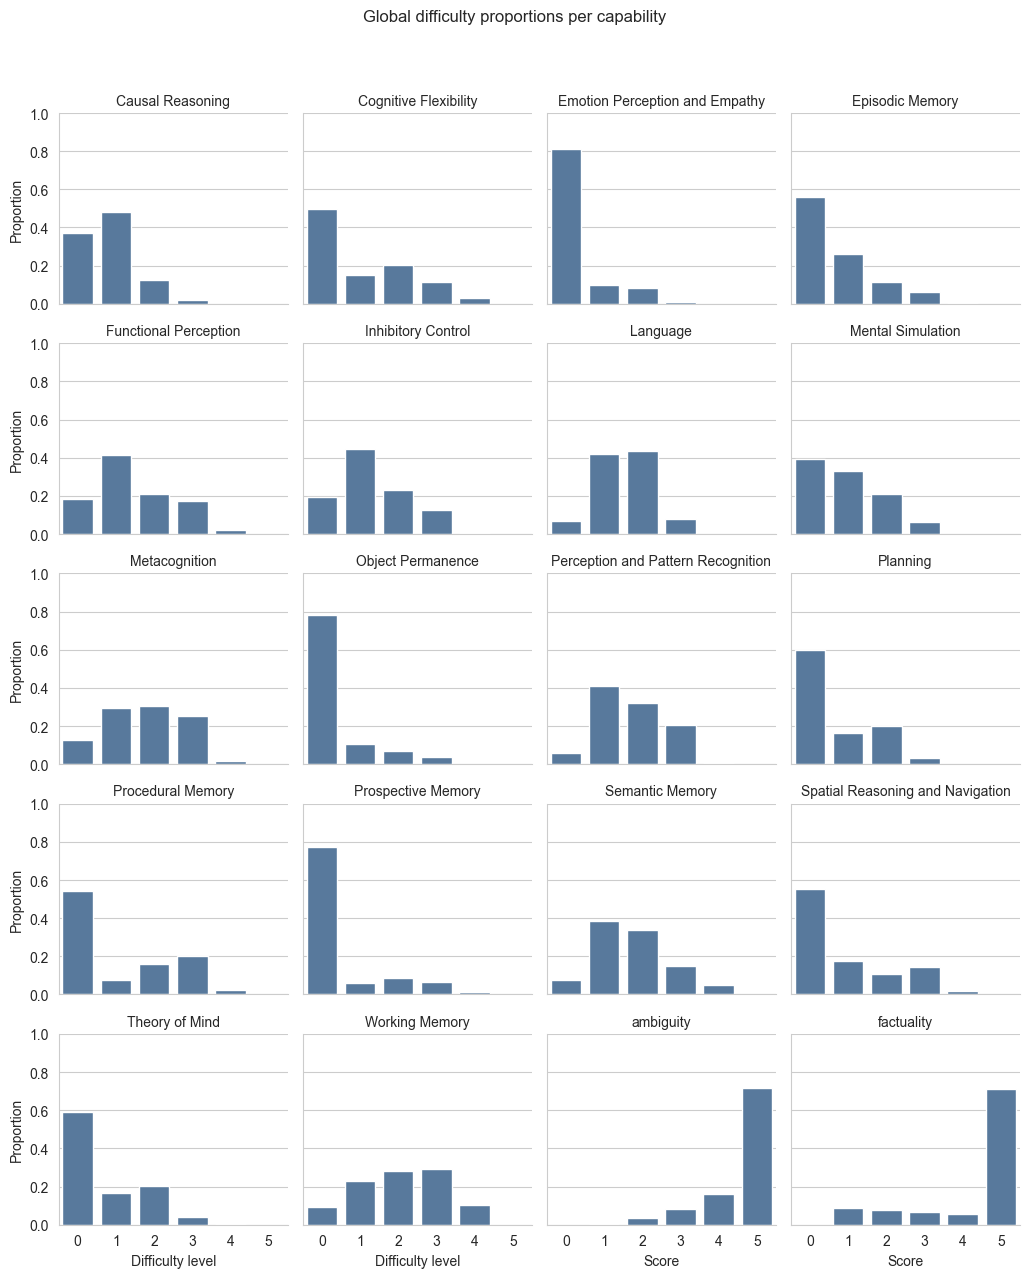

In [19]:
df_long = p_global.reset_index().melt(id_vars="dimension", var_name="score", value_name="proportion")

g = sns.FacetGrid(df_long, col="dimension", col_wrap=4, sharex=True, sharey=True, height=2.6)
g.map_dataframe(sns.barplot, x="score", y="proportion", color="#4C78A8")
g.set_titles("{col_name}")
g.set_xlabels("Difficulty level")
g.set_ylabels("Proportion")

for ax in g.axes.flat:
    if ax is None:
        continue
    title = ax.get_title()  # equals the dimension name from {col_name}
    if title in {"ambiguity", "factuality"}:
        ax.set_xlabel("Score")
    ax.set_ylim(0, 1)

plt.subplots_adjust(top=0.9)
g.figure.suptitle("Global difficulty proportions per capability")
plt.show()

# Per dataset difficulty proportions per capability

In [20]:
datasets = sorted(items_per_dataset.index.tolist())

In [21]:
SCORE_BINS = list(range(6))

# Count scores per dataset and dimension
counts = (
    data_filtered.groupby(["dataset name", "dimension", "score"])
        .size()
        .unstack("score", fill_value=0)
        .reindex(columns=SCORE_BINS, fill_value=0)
)

denom = counts.sum(axis=1)
p_per_ds_dim = counts.div(denom, axis=0)
p_per_ds_dim.head()

score                                                   0         1         2  \
dataset name     dimension                                                      
AGIEval_freeform Causal Reasoning                0.959276  0.029412  0.010181   
                 Cognitive Flexibility           0.639140  0.052036  0.190045   
                 Emotion Perception and Empathy  1.000000  0.000000  0.000000   
                 Episodic Memory                 0.998869  0.000000  0.001131   
                 Functional Perception           0.472851  0.132353  0.305430   

score                                                   3         4    5  
dataset name     dimension                                                
AGIEval_freeform Causal Reasoning                0.001131  0.000000  0.0  
                 Cognitive Flexibility           0.106335  0.012443  0.0  
                 Emotion Perception and Empathy  0.000000  0.000000  0.0  
                 Episodic Memory                 0.000000  0.000000  0.0  
                 Functional Perception           0.089367  0.000000  0.0

In [22]:
p_per_ds_dim.loc["Crow"]

score,0,1,2,3,4,5
dimension,,,,,,
Causal Reasoning,0.2855,0.6750,0.0320,0.0065,0.0010,0.0000
Cognitive Flexibility,0.6370,0.2125,0.1185,0.0290,0.0030,0.0000
Emotion Perception and Empathy,0.6625,0.2365,0.0945,0.0065,0.0000,0.0000
Episodic Memory,0.7170,0.2160,0.0560,0.0105,0.0005,0.0000
Functional Perception,0.2110,0.6085,0.1375,0.0345,0.0080,0.0005
Inhibitory Control,0.4255,0.3735,0.0955,0.0855,0.0190,0.0010
Language,0.0060,0.6535,0.2985,0.0420,0.0000,0.0000
Mental Simulation,0.4825,0.4900,0.0230,0.0040,0.0005,0.0000
Metacognition,0.2345,0.4245,0.2300,0.0985,0.0125,0.0000


In [23]:
p_per_ds_dim.loc["LLM_BabyBench_plan"]

score,0,1,2,3,4,5
dimension,,,,,,
Causal Reasoning,0.077778,0.805556,0.116667,0.000000,0.000000,0.000000
Cognitive Flexibility,0.672222,0.144444,0.150000,0.033333,0.000000,0.000000
Emotion Perception and Empathy,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Episodic Memory,0.661111,0.222222,0.088889,0.022222,0.005556,0.000000
Functional Perception,0.022222,0.383333,0.500000,0.094444,0.000000,0.000000
Inhibitory Control,0.100000,0.466667,0.366667,0.061111,0.005556,0.000000
Language,0.033333,0.466667,0.488889,0.011111,0.000000,0.000000
Mental Simulation,0.000000,0.138889,0.733333,0.127778,0.000000,0.000000
Metacognition,0.011111,0.177778,0.427778,0.372222,0.011111,0.000000


In [24]:
# Prepare long-form data
plot_df = (
    p_per_ds_dim
    .reset_index()                                  # columns: dataset name, dimension, 0..5
    .melt(id_vars=["dataset name", "dimension"],
          var_name="difficulty", value_name="Proportion")  # difficulty is the score bin (0..5)
)

# Ensure proper dtypes/order
plot_df["difficulty"] = plot_df["difficulty"].astype(int)
plot_df = plot_df.sort_values(["dataset name", "dimension", "difficulty"])

In [25]:
plot_df.head()

,dataset name,dimension,difficulty,Proportion
0,AGIEval_freeform,Causal Reasoning,0,0.959276
520,AGIEval_freeform,Causal Reasoning,1,0.029412
1040,AGIEval_freeform,Causal Reasoning,2,0.010181
1560,AGIEval_freeform,Causal Reasoning,3,0.001131
2080,AGIEval_freeform,Causal Reasoning,4,0.000000


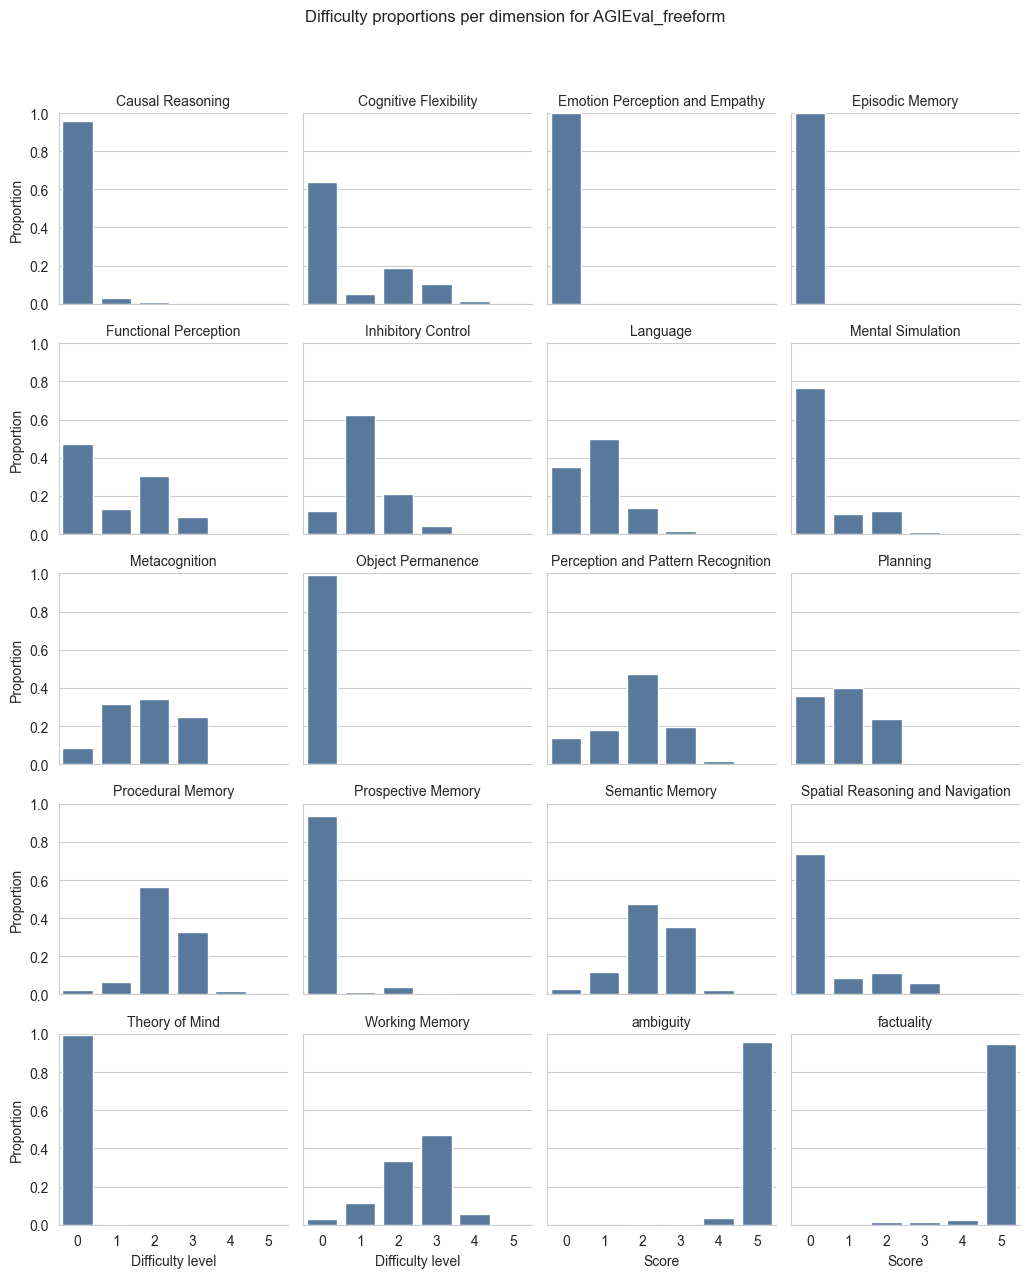

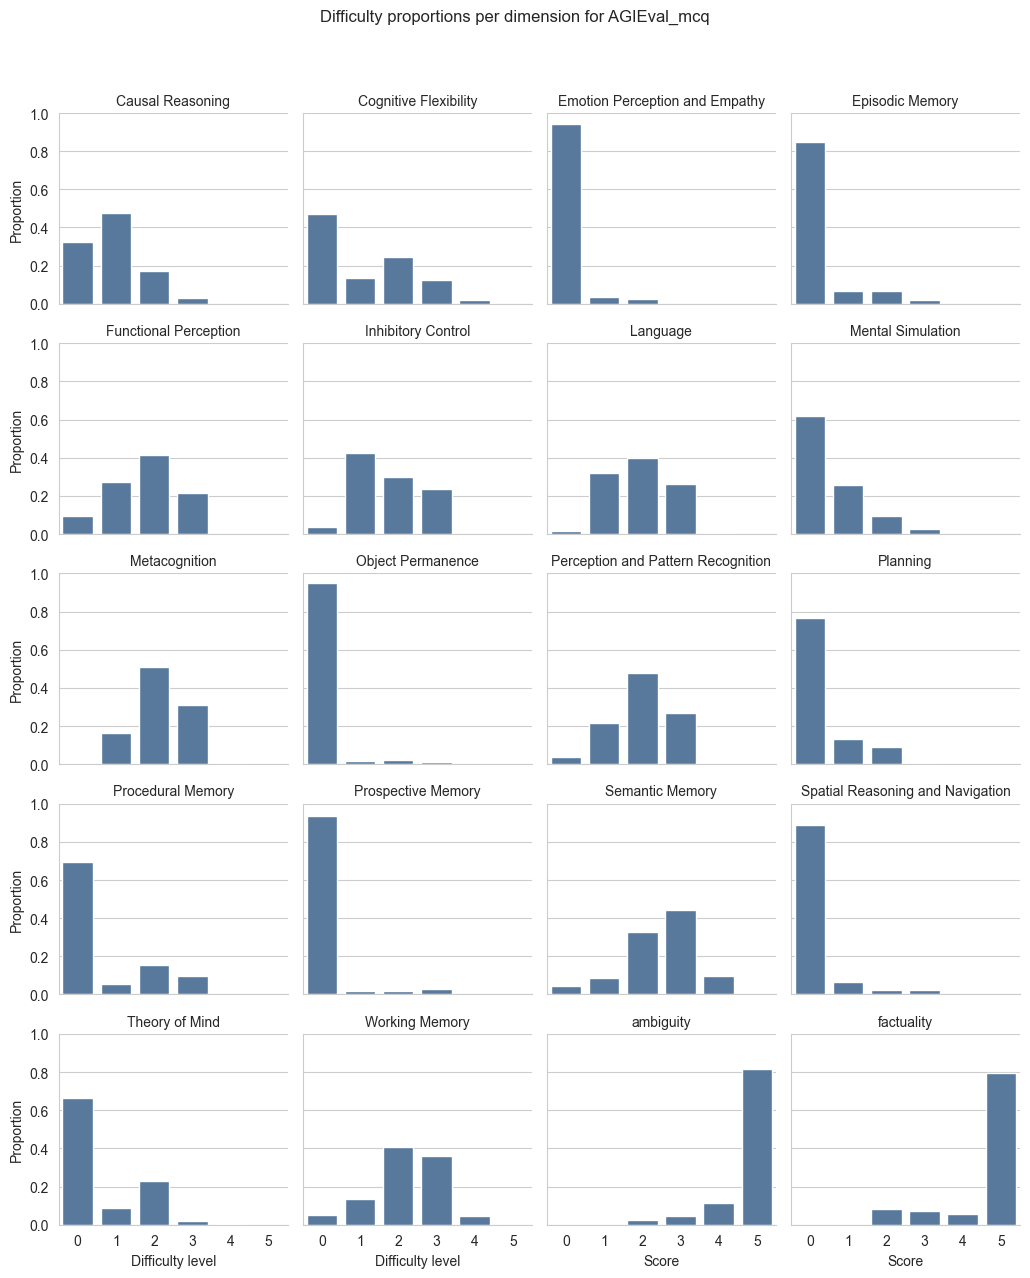

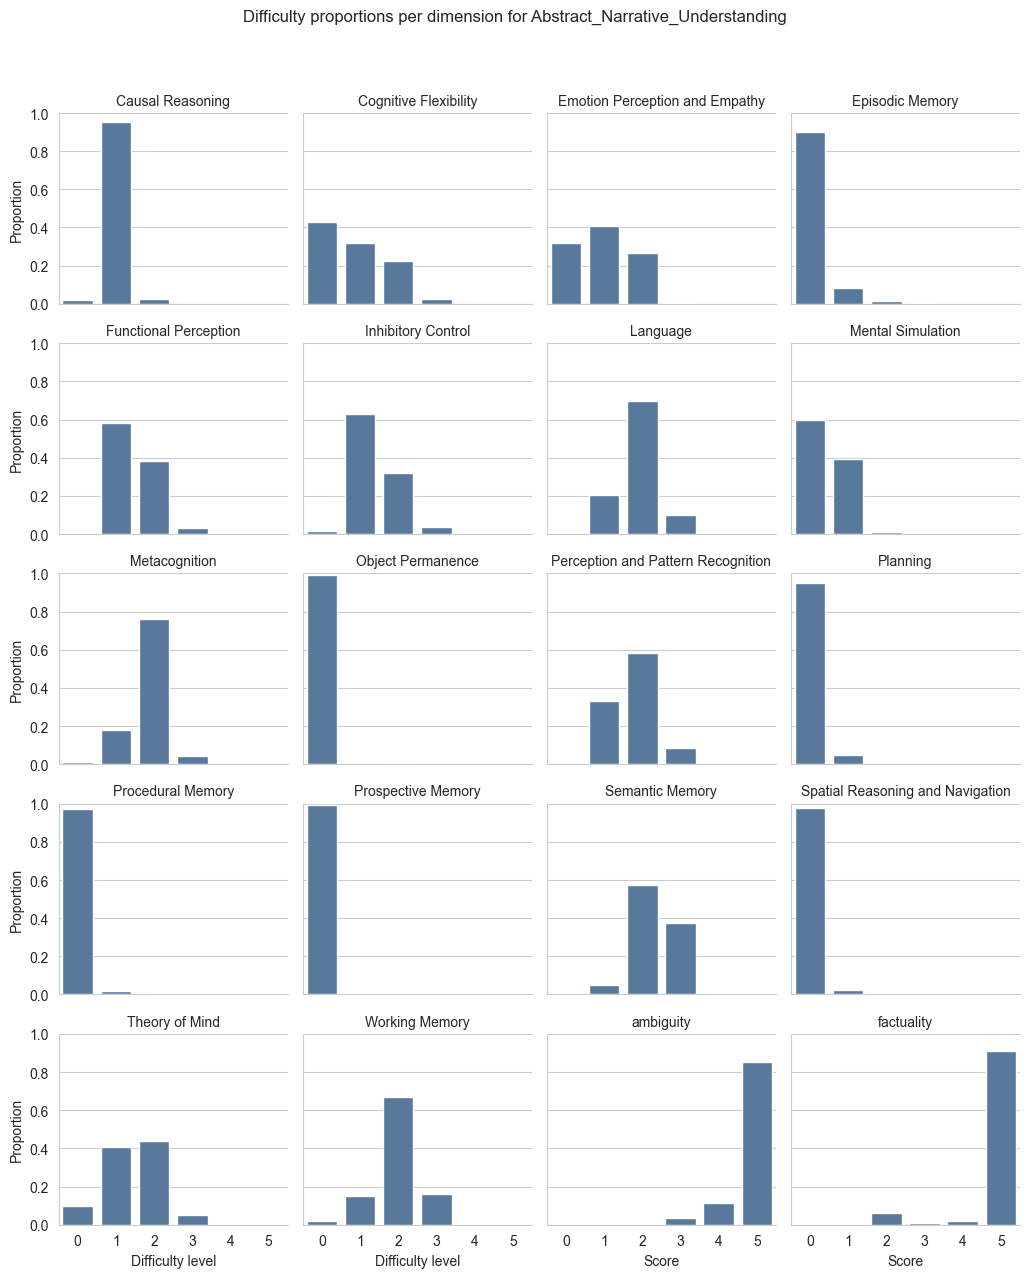

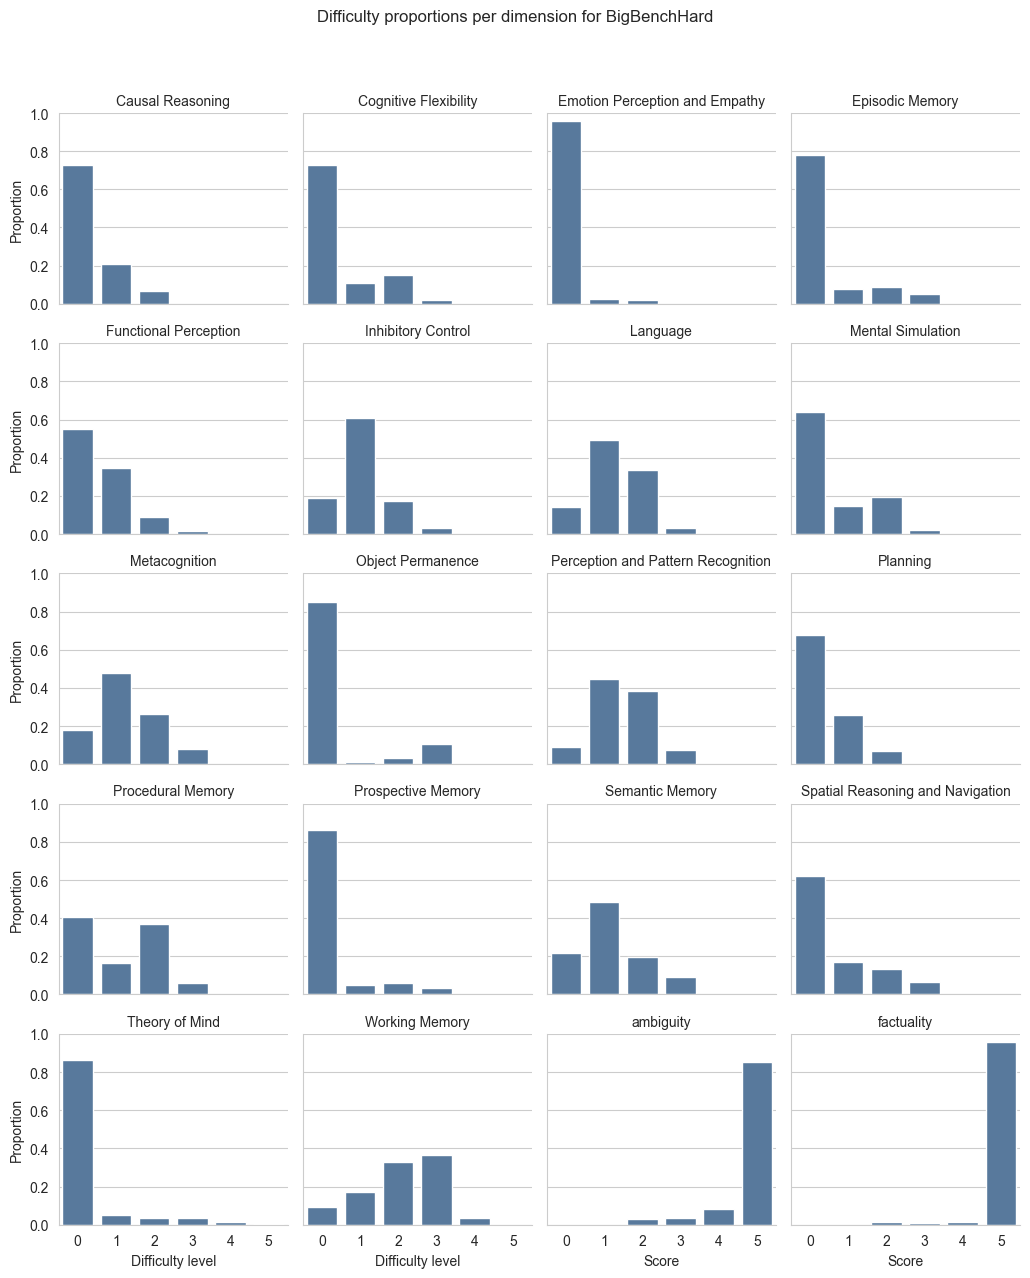

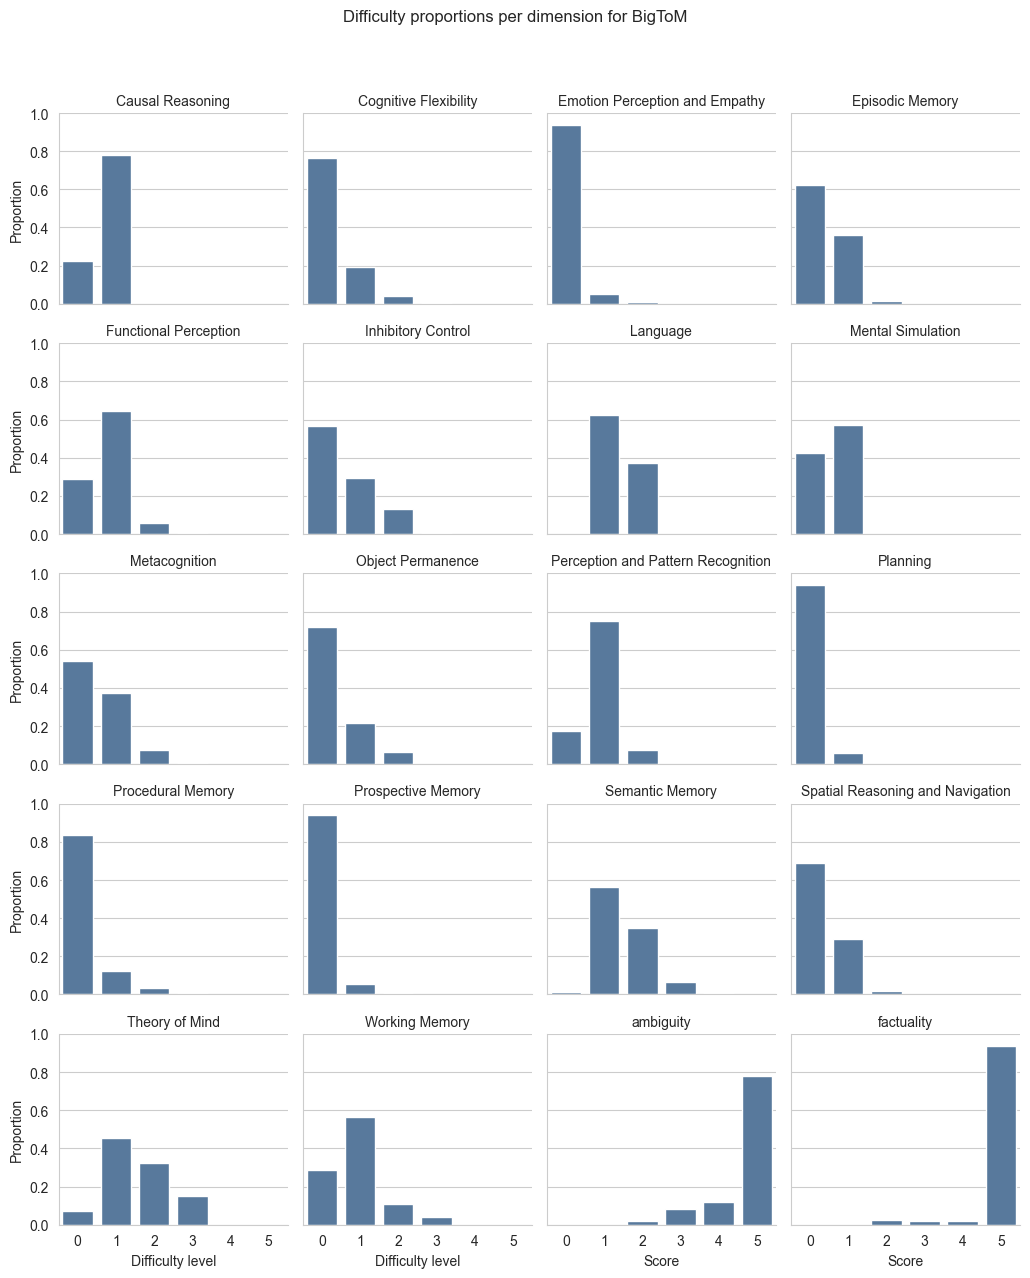

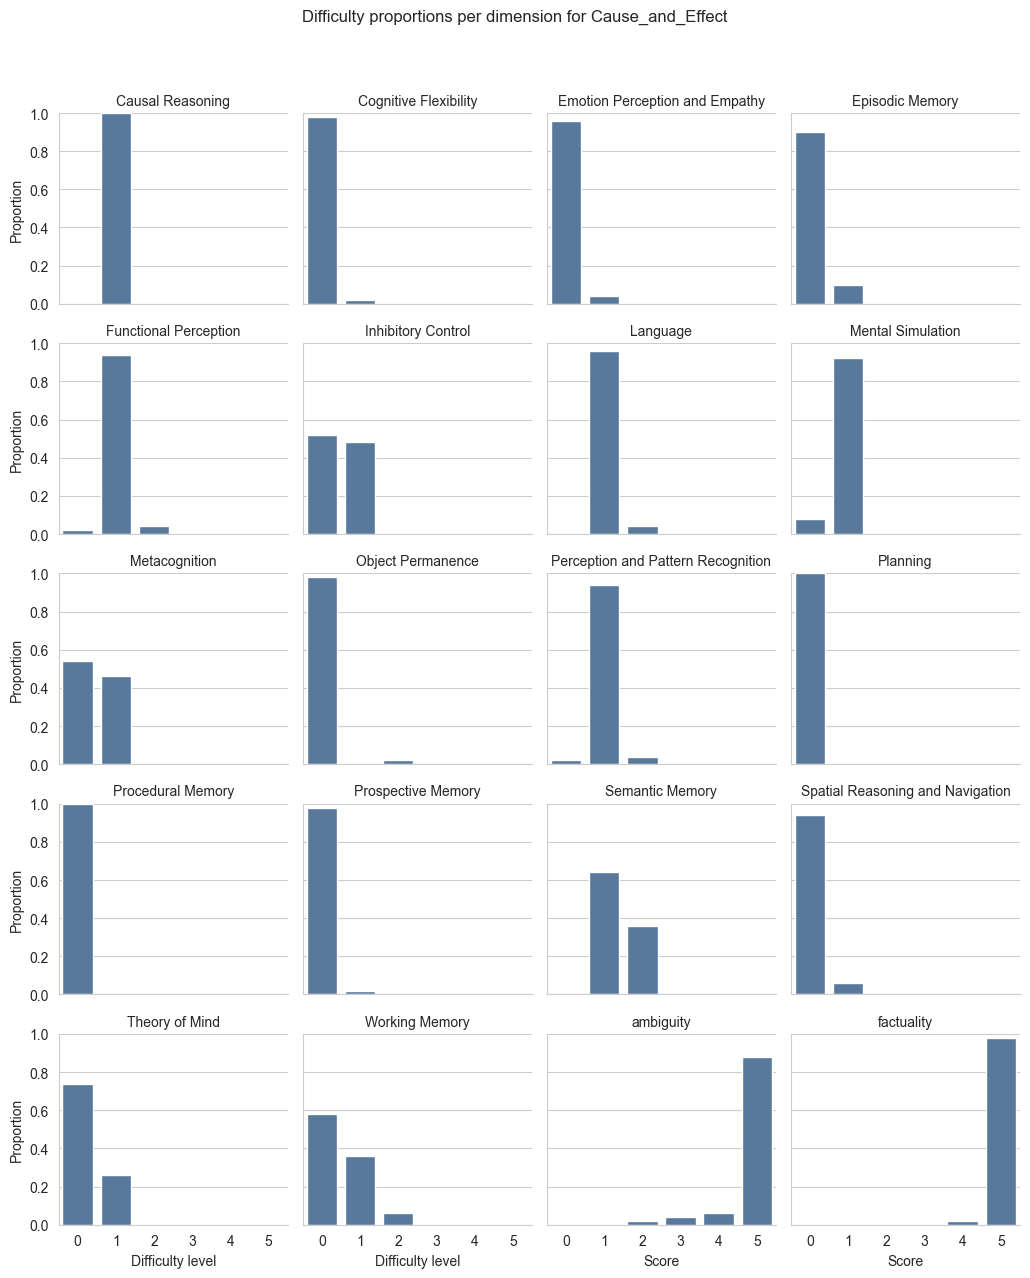

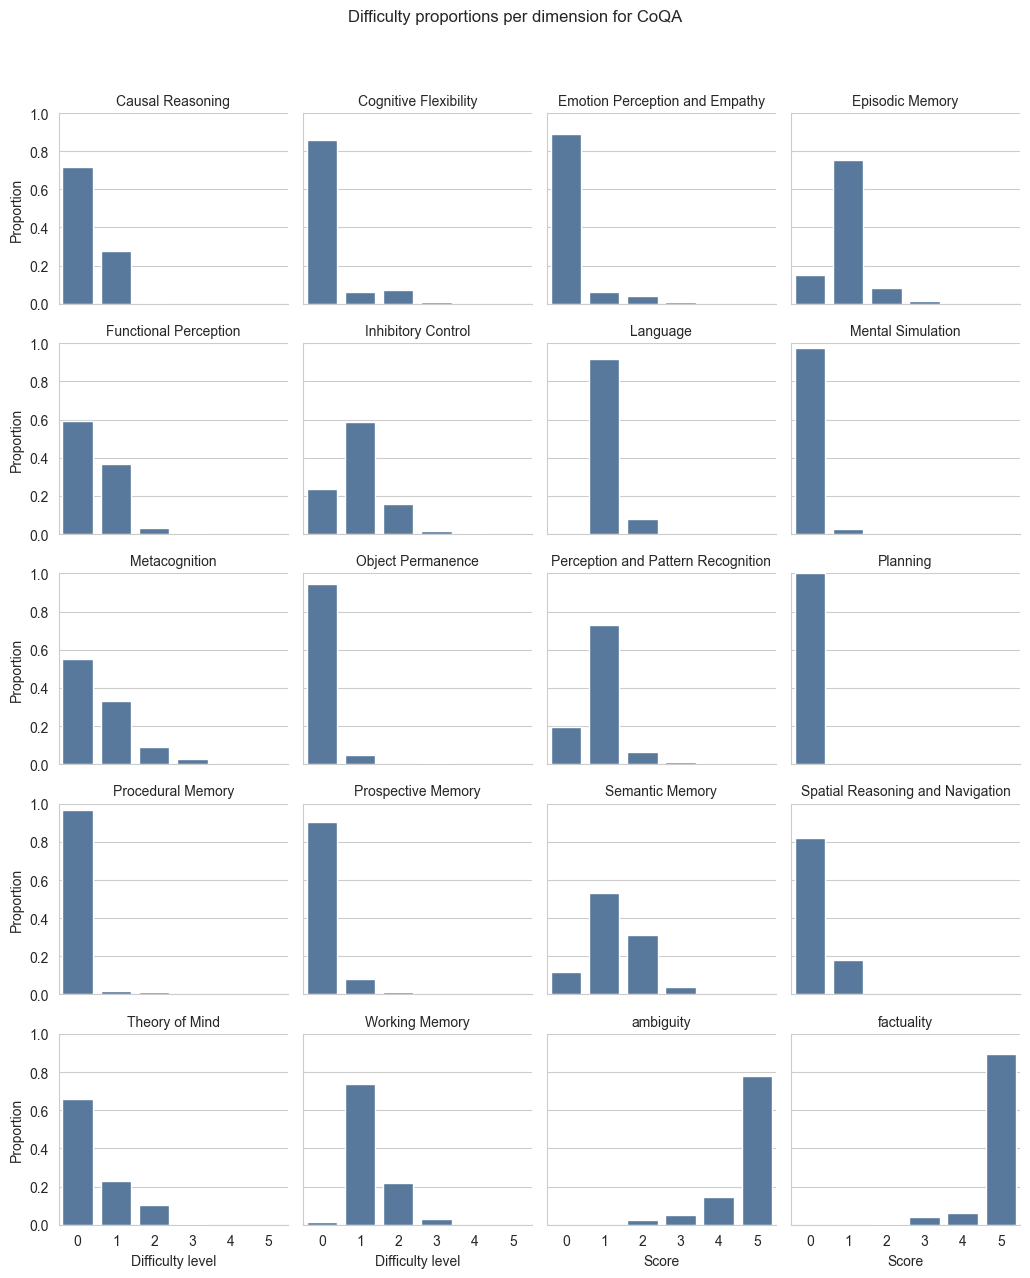

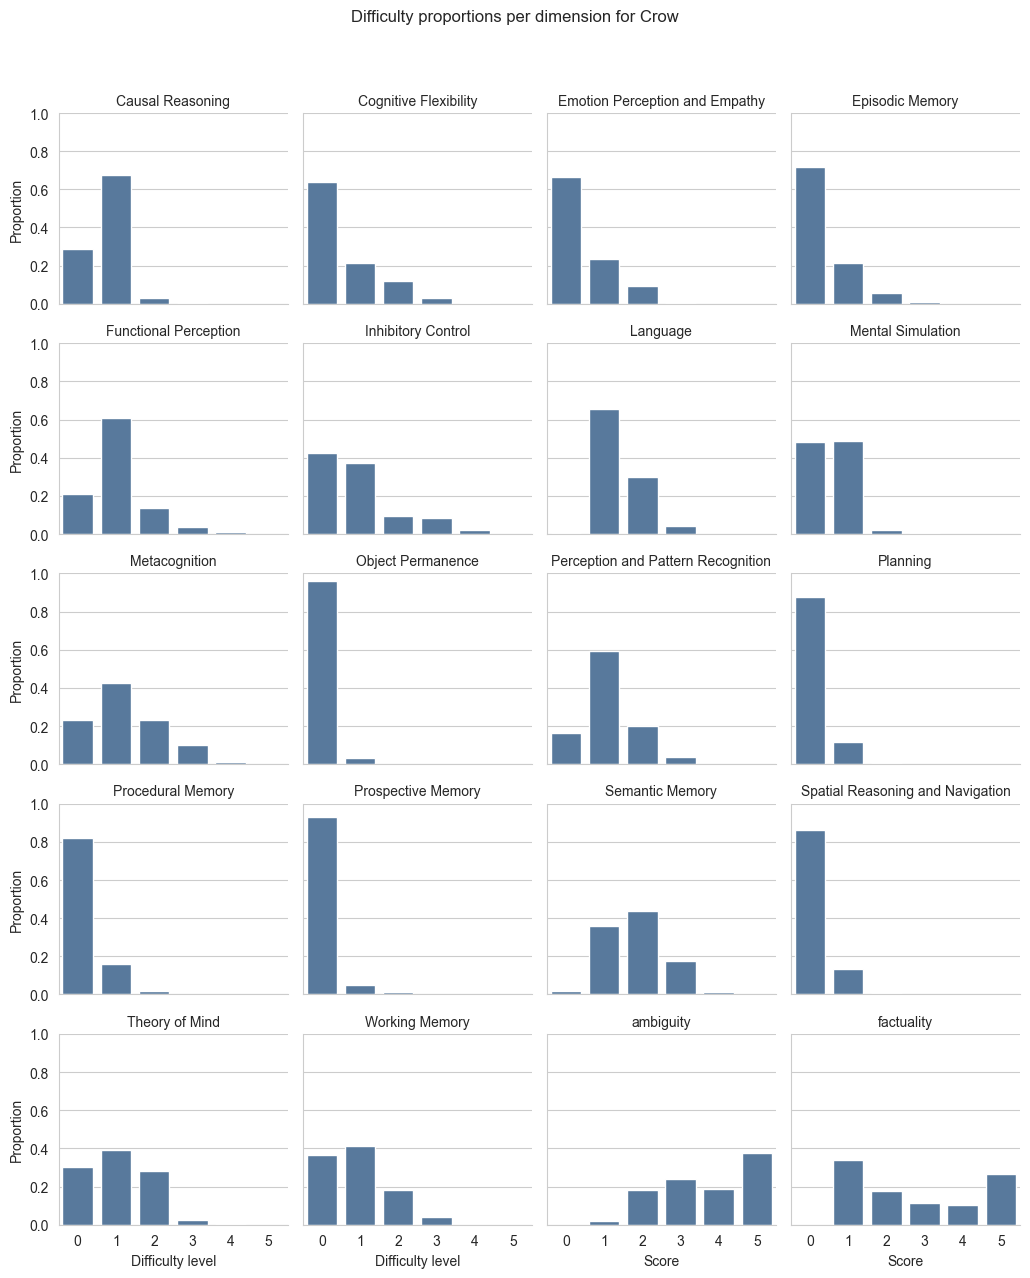

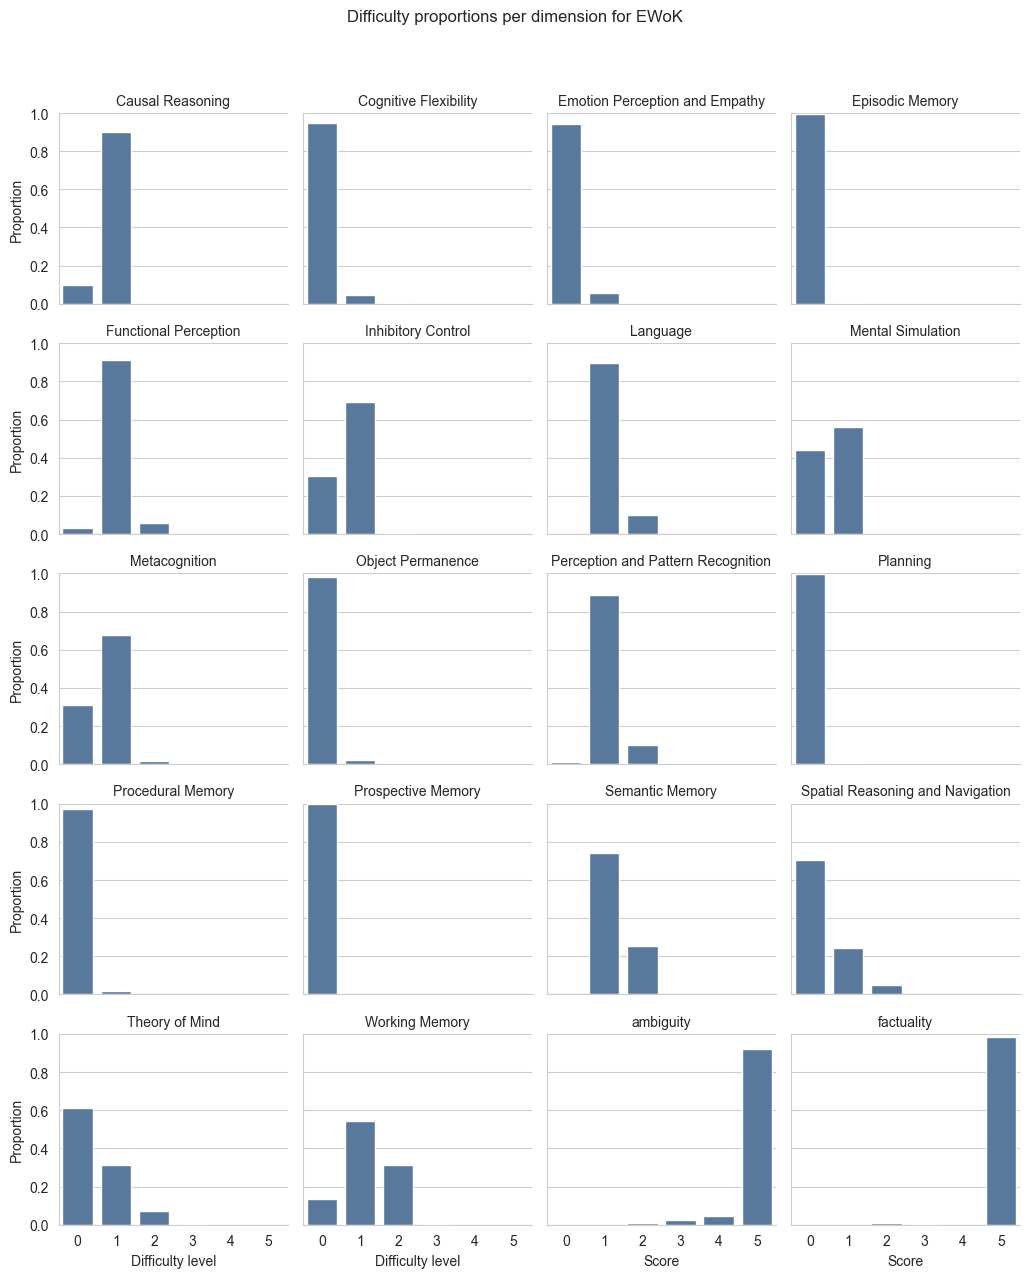

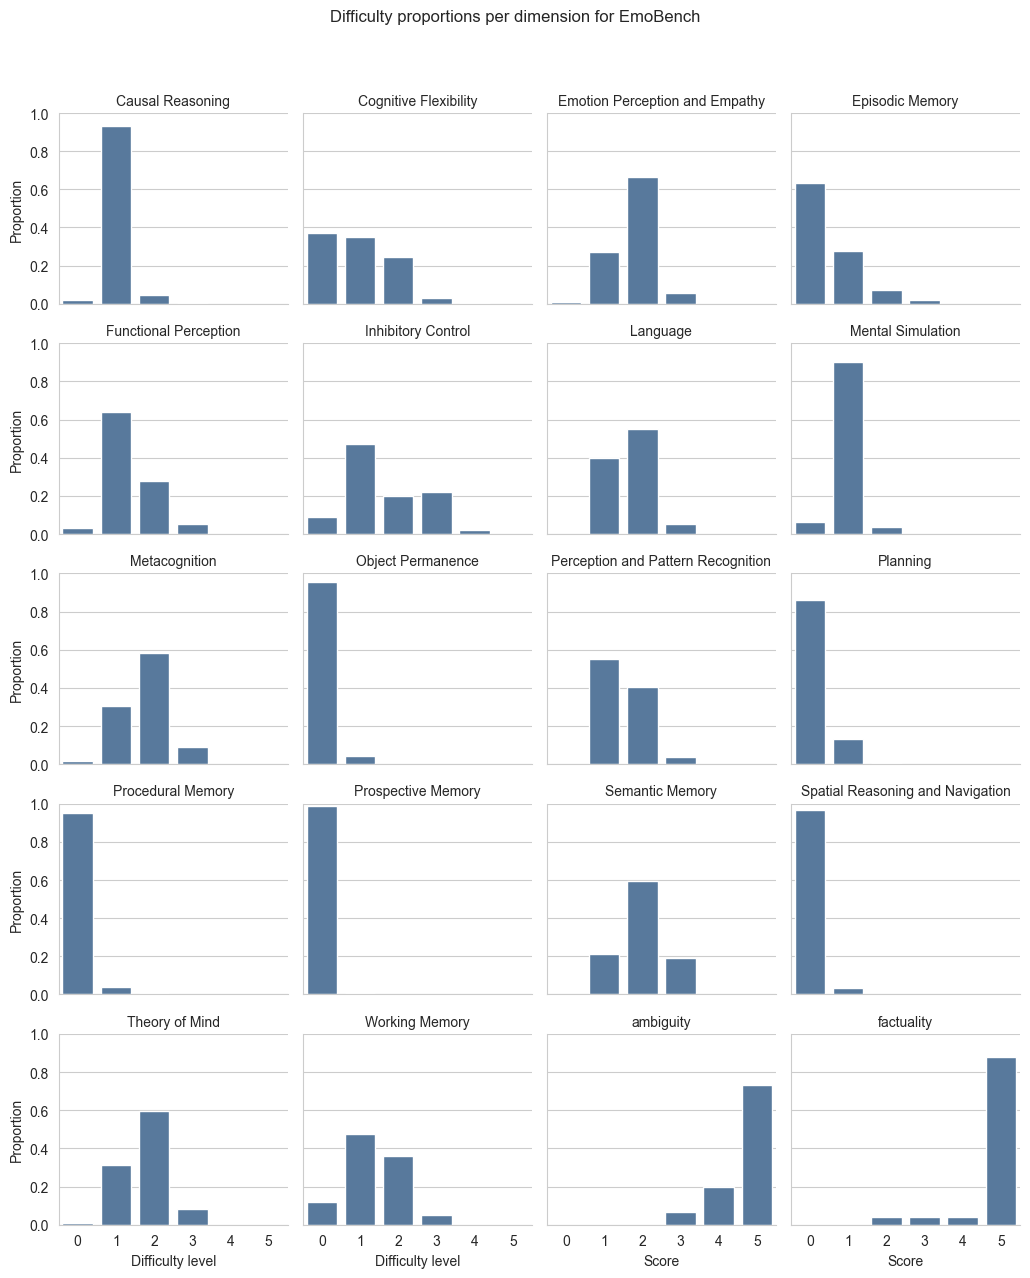

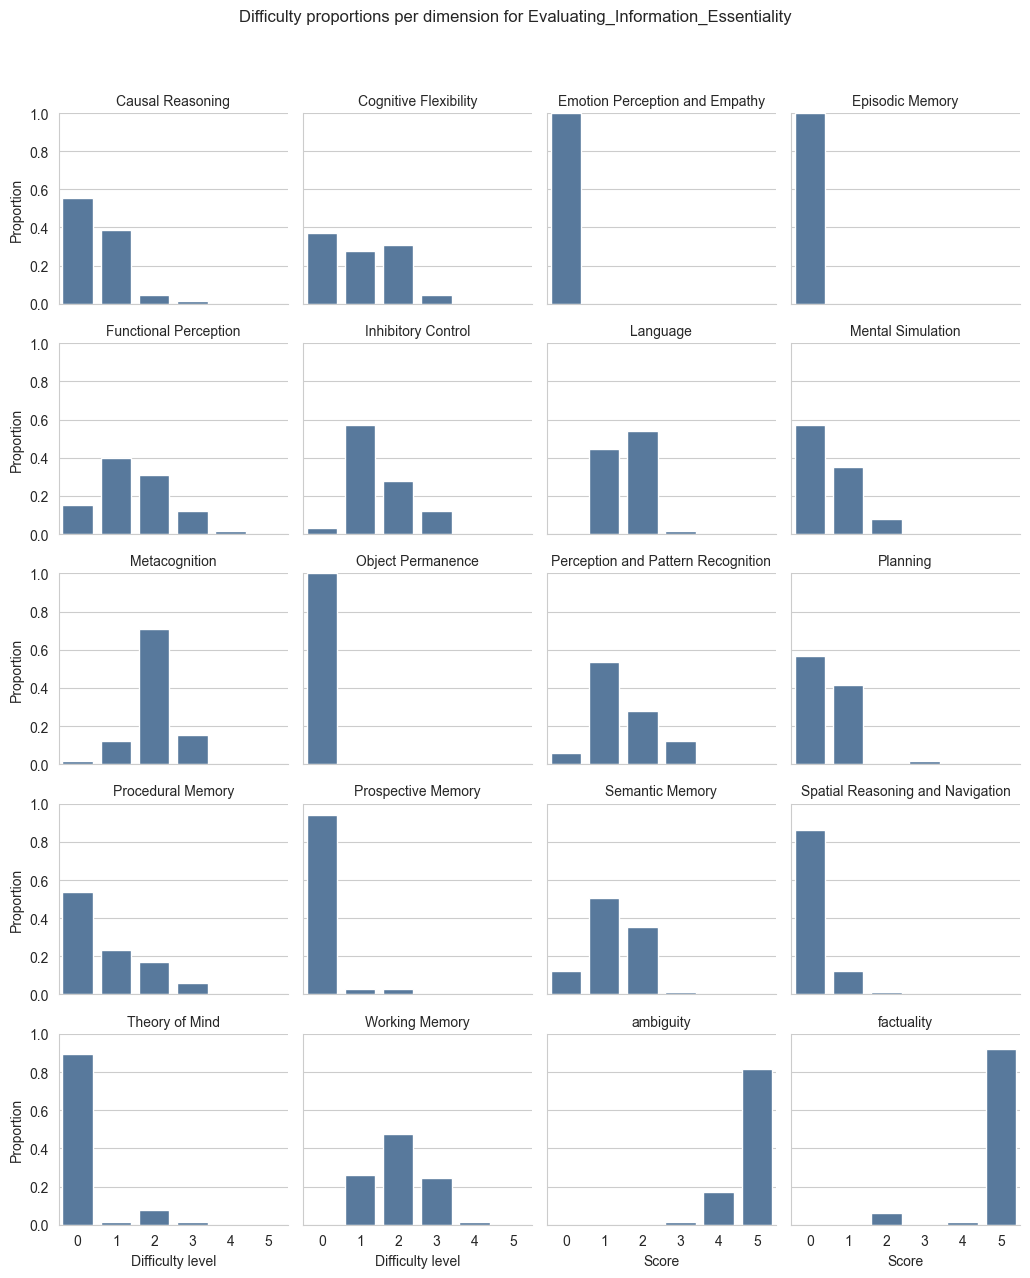

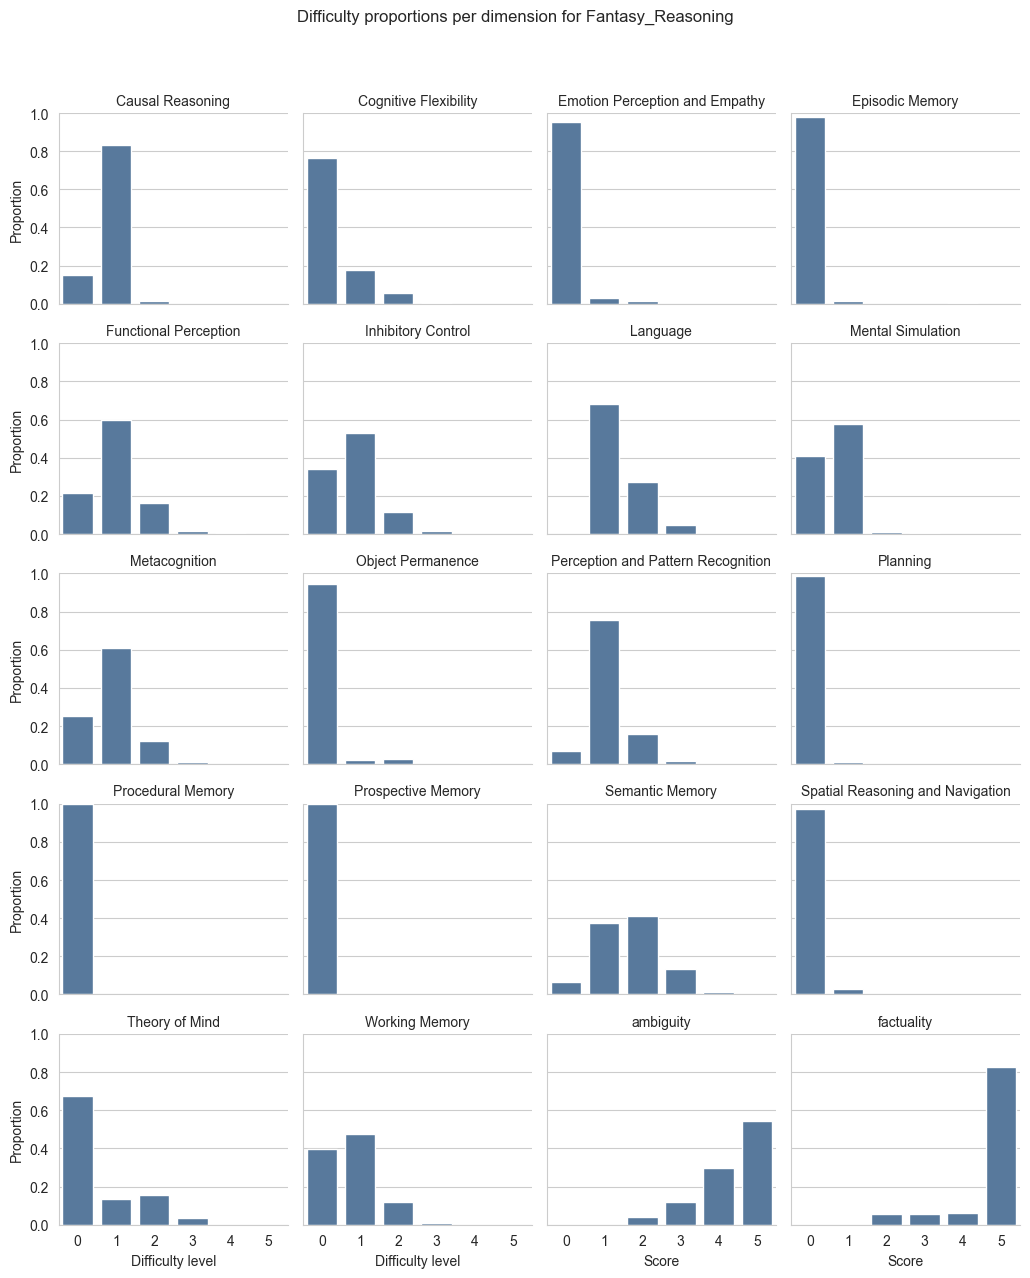

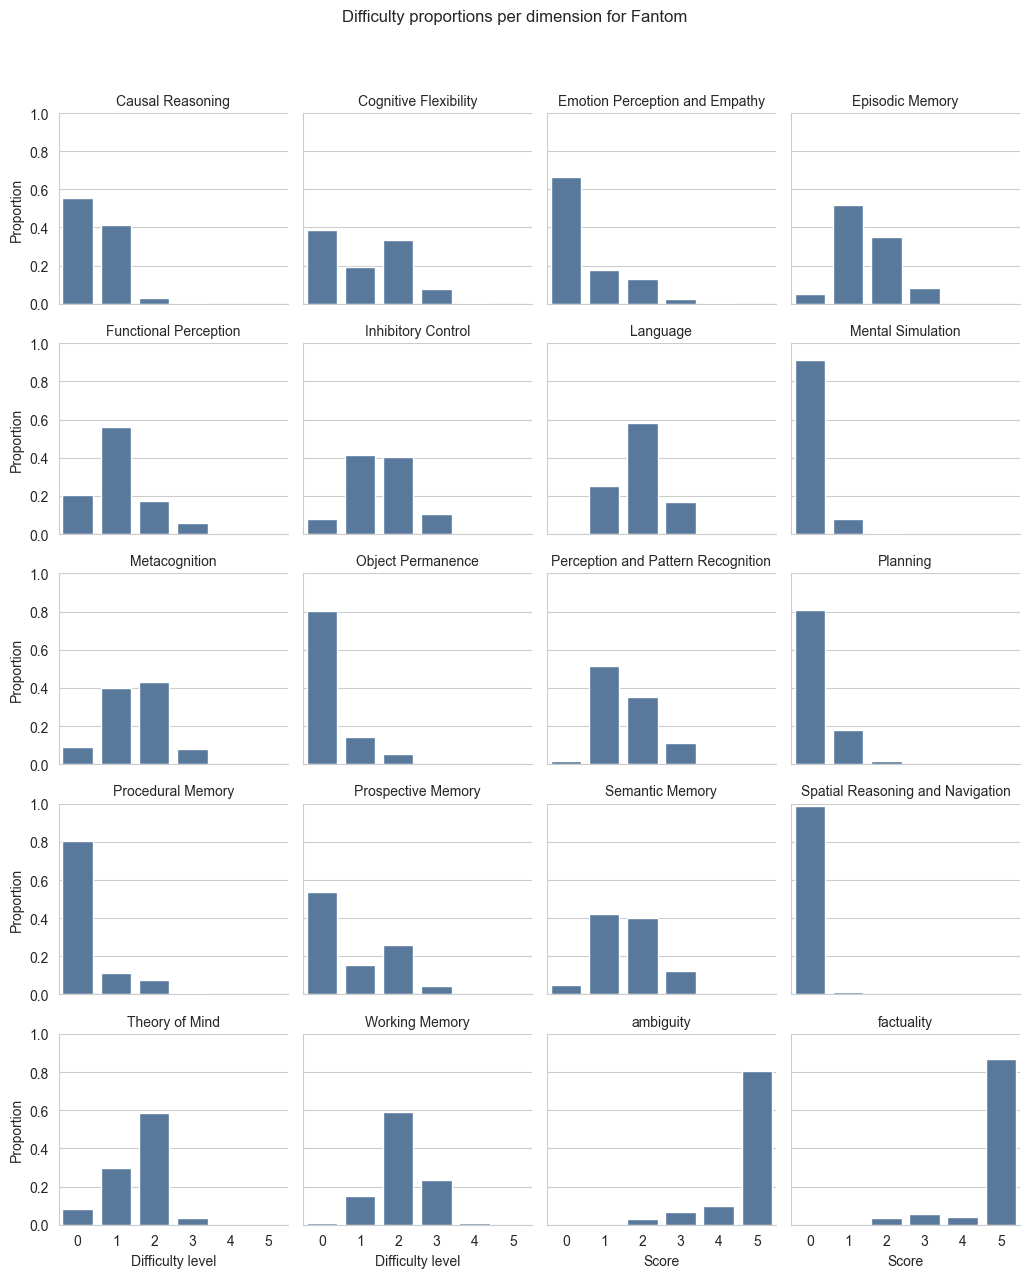

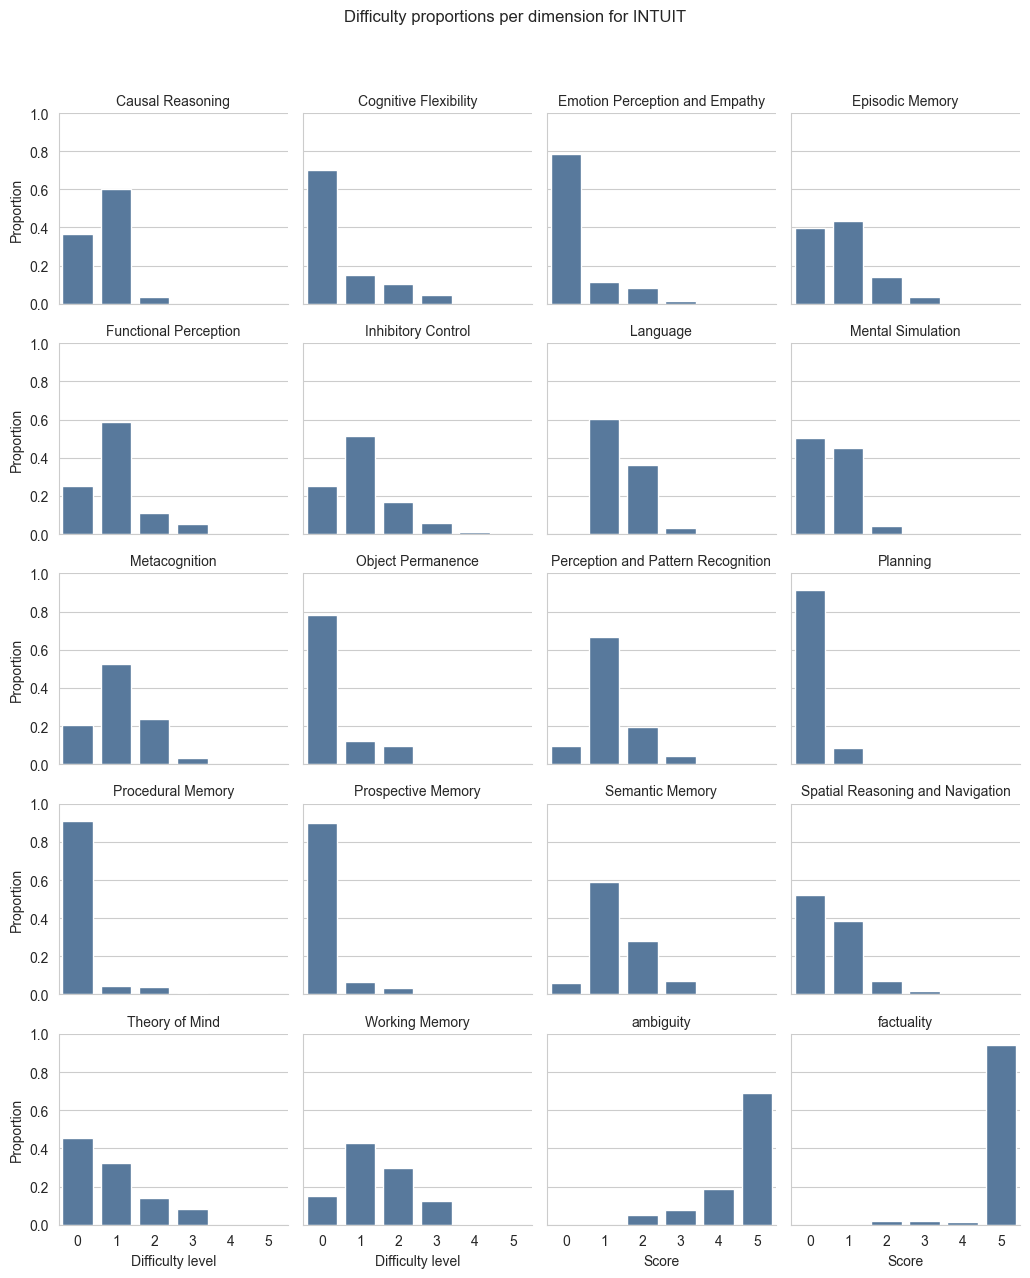

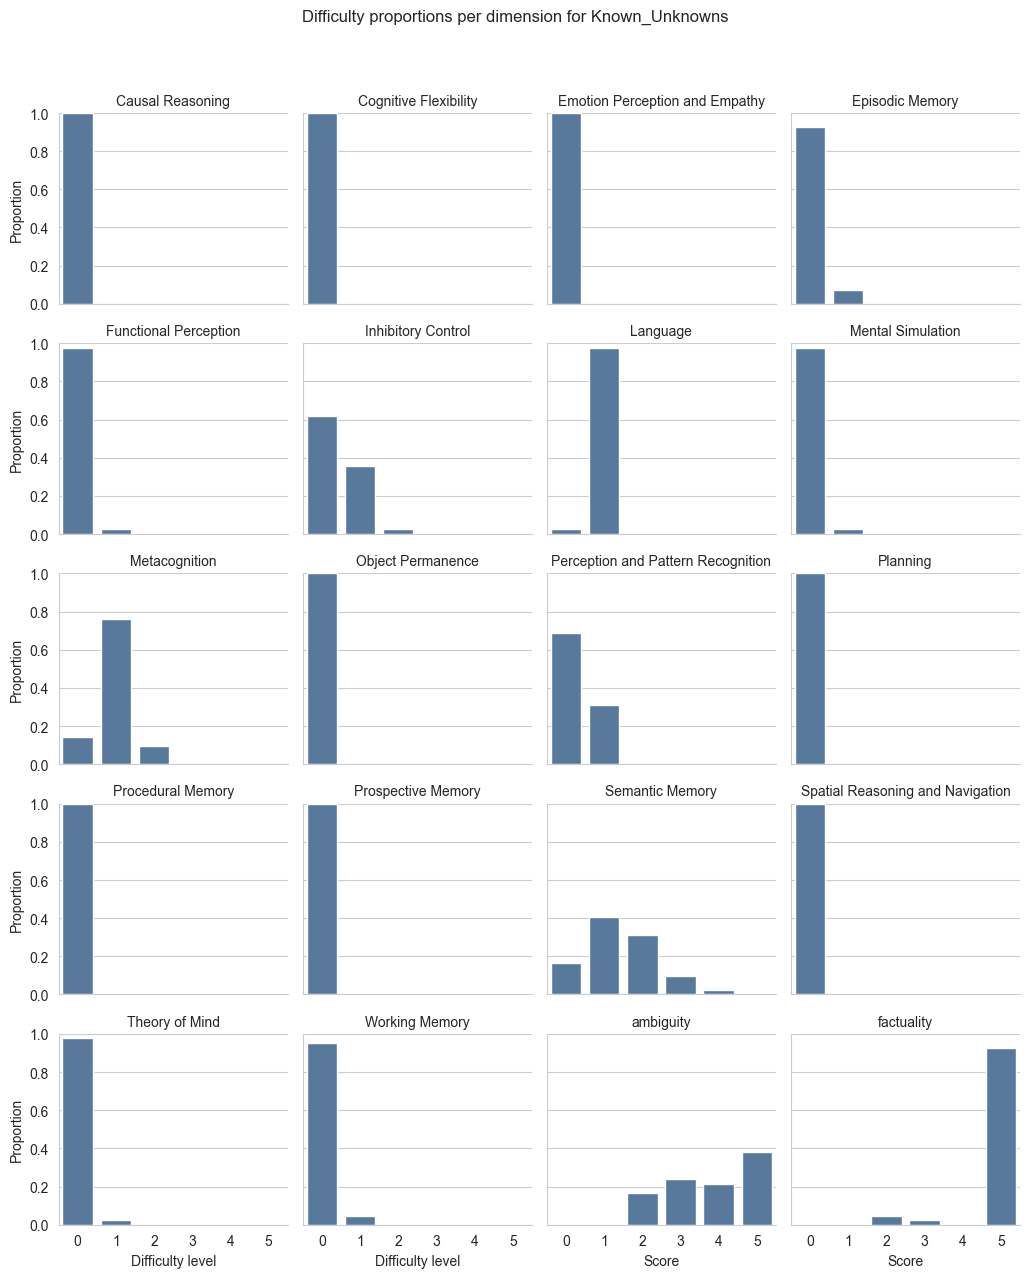

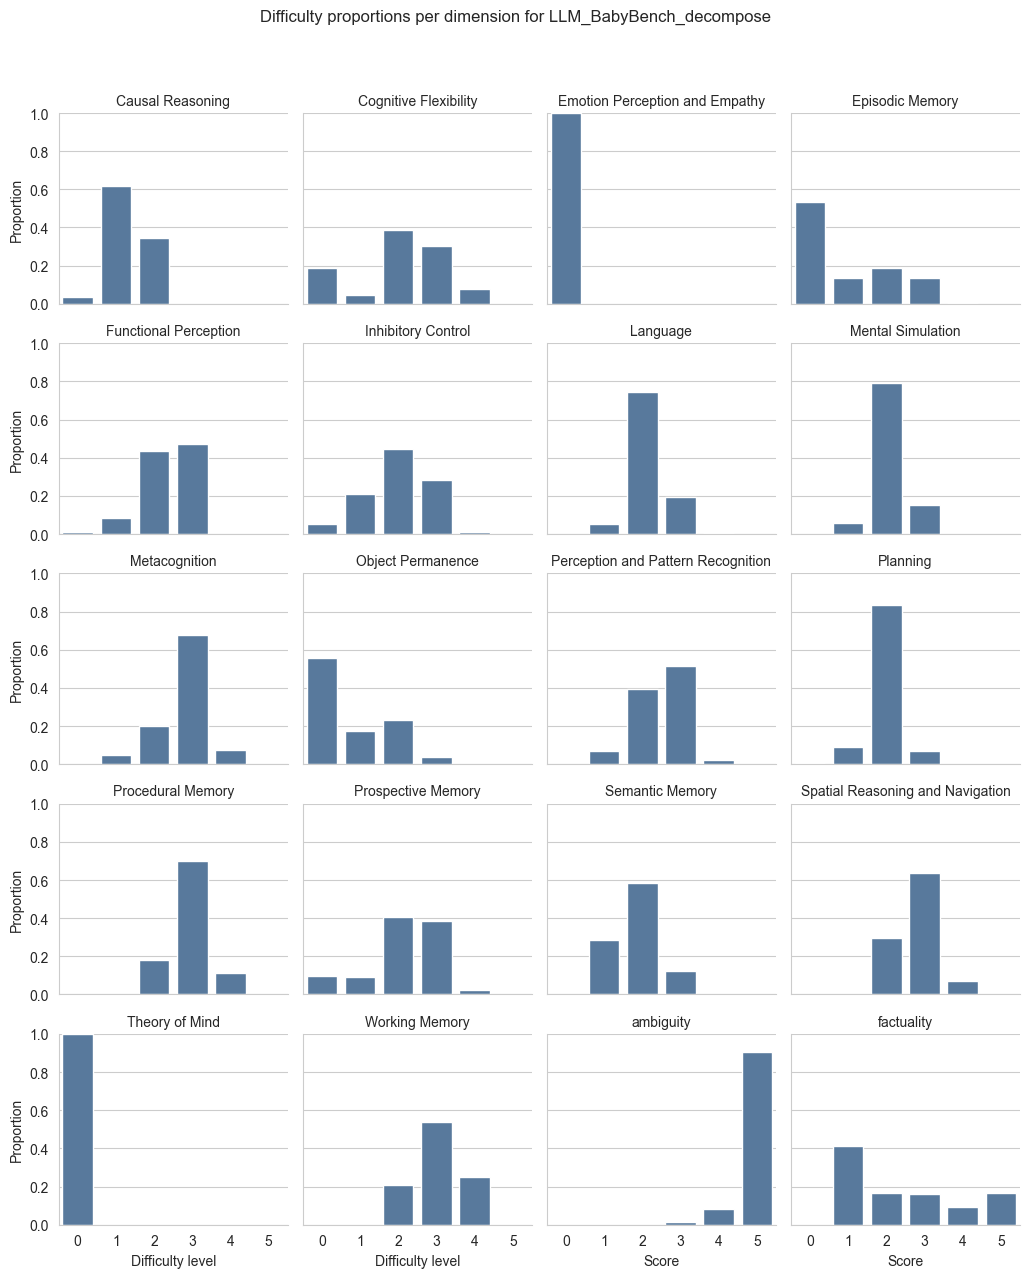

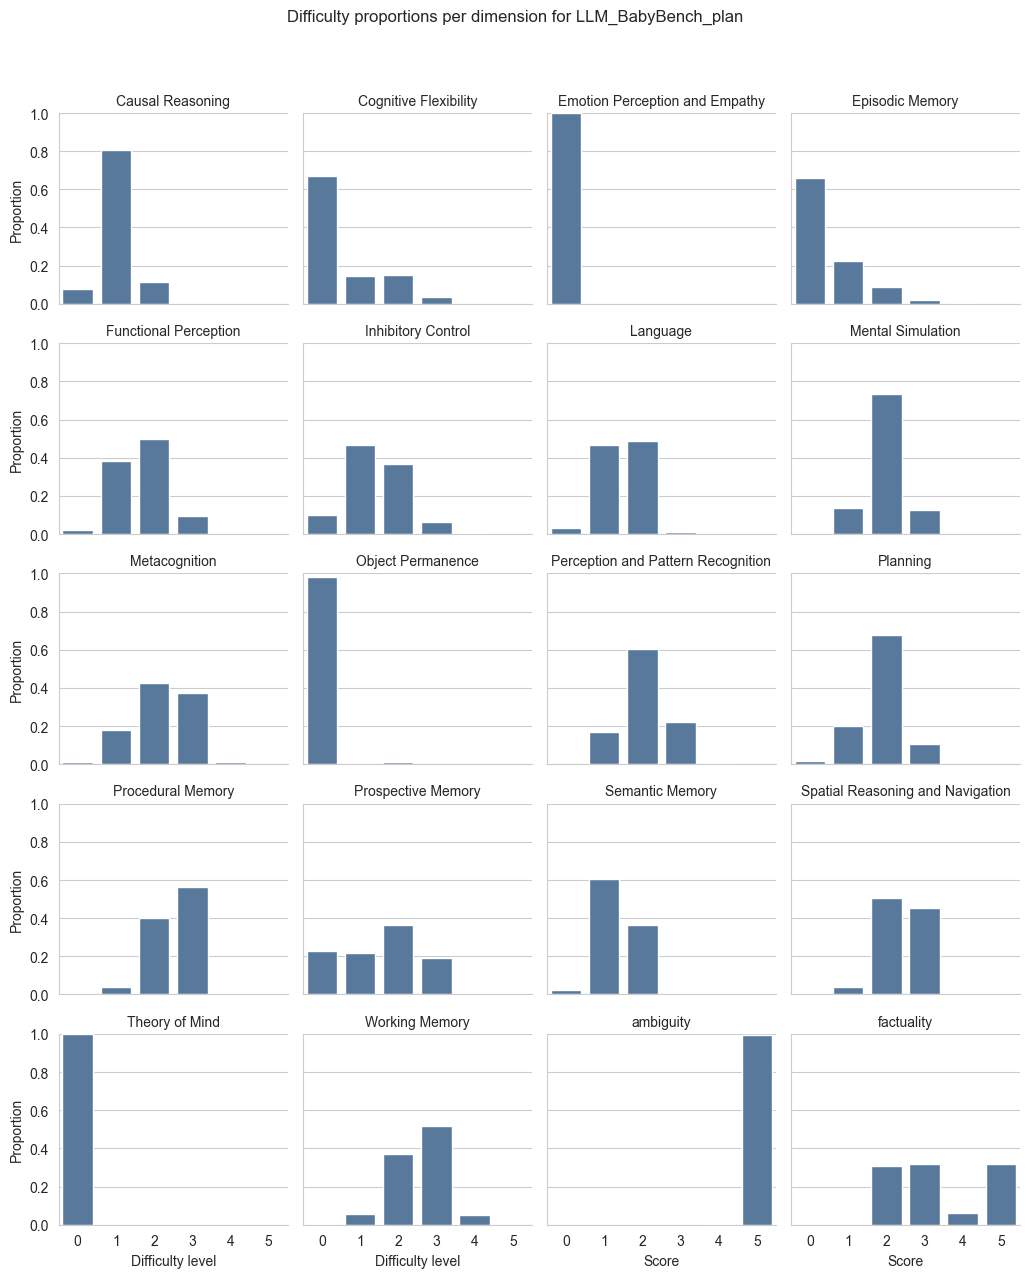

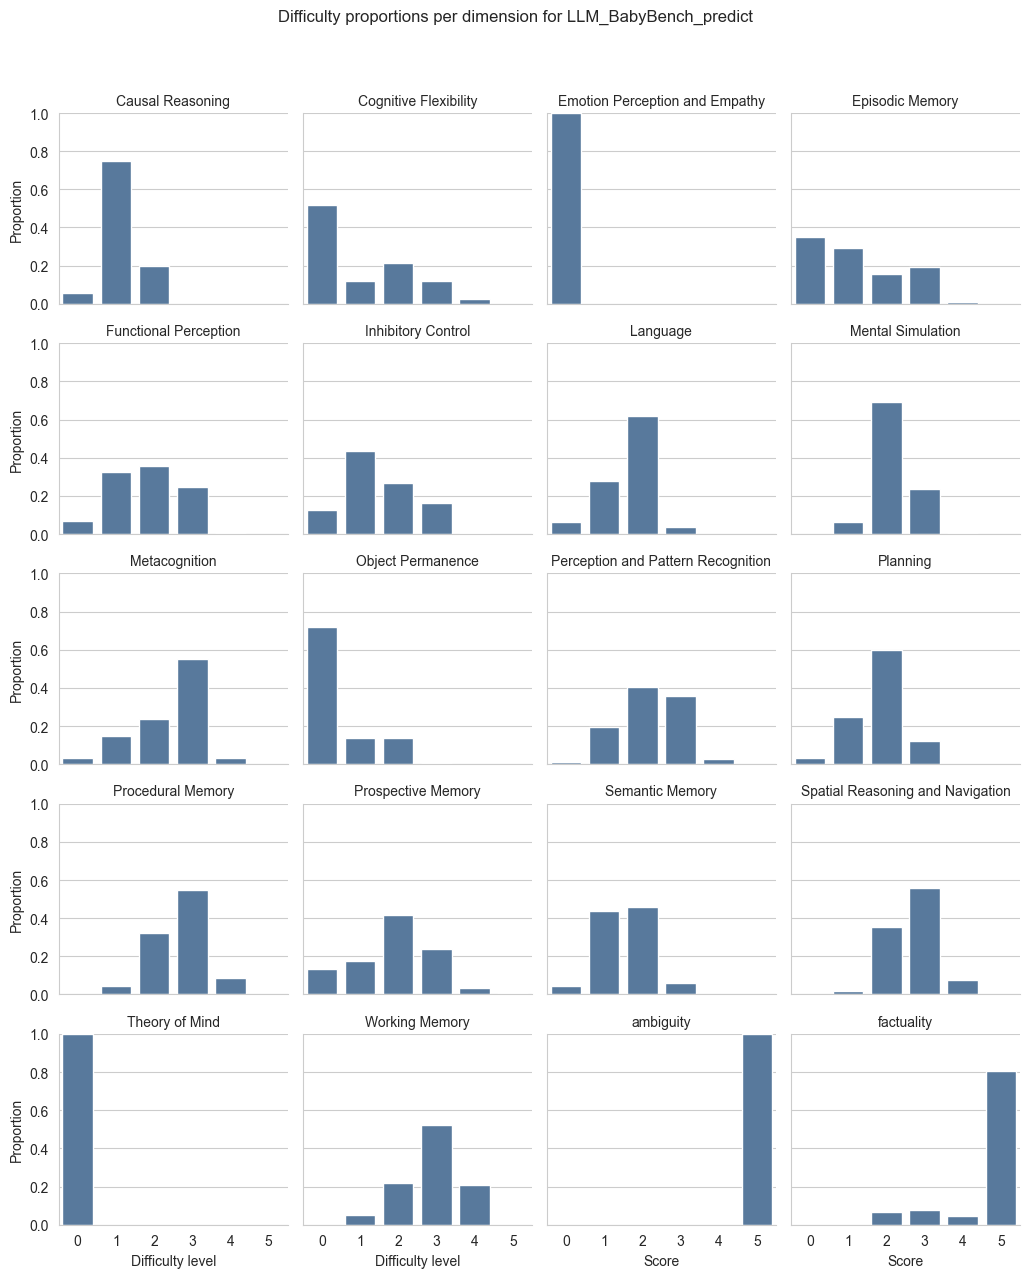

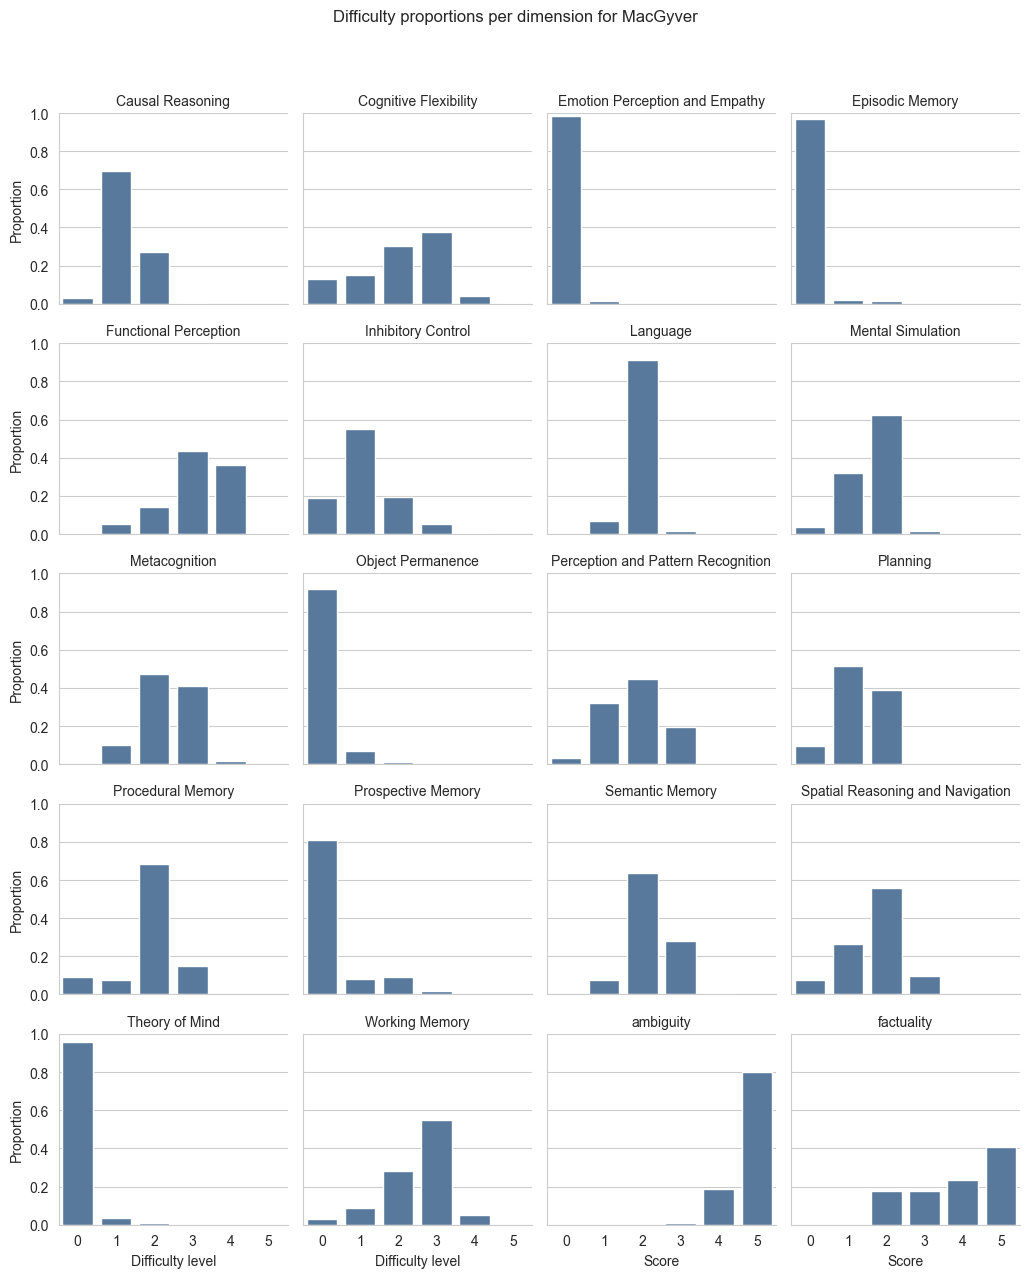

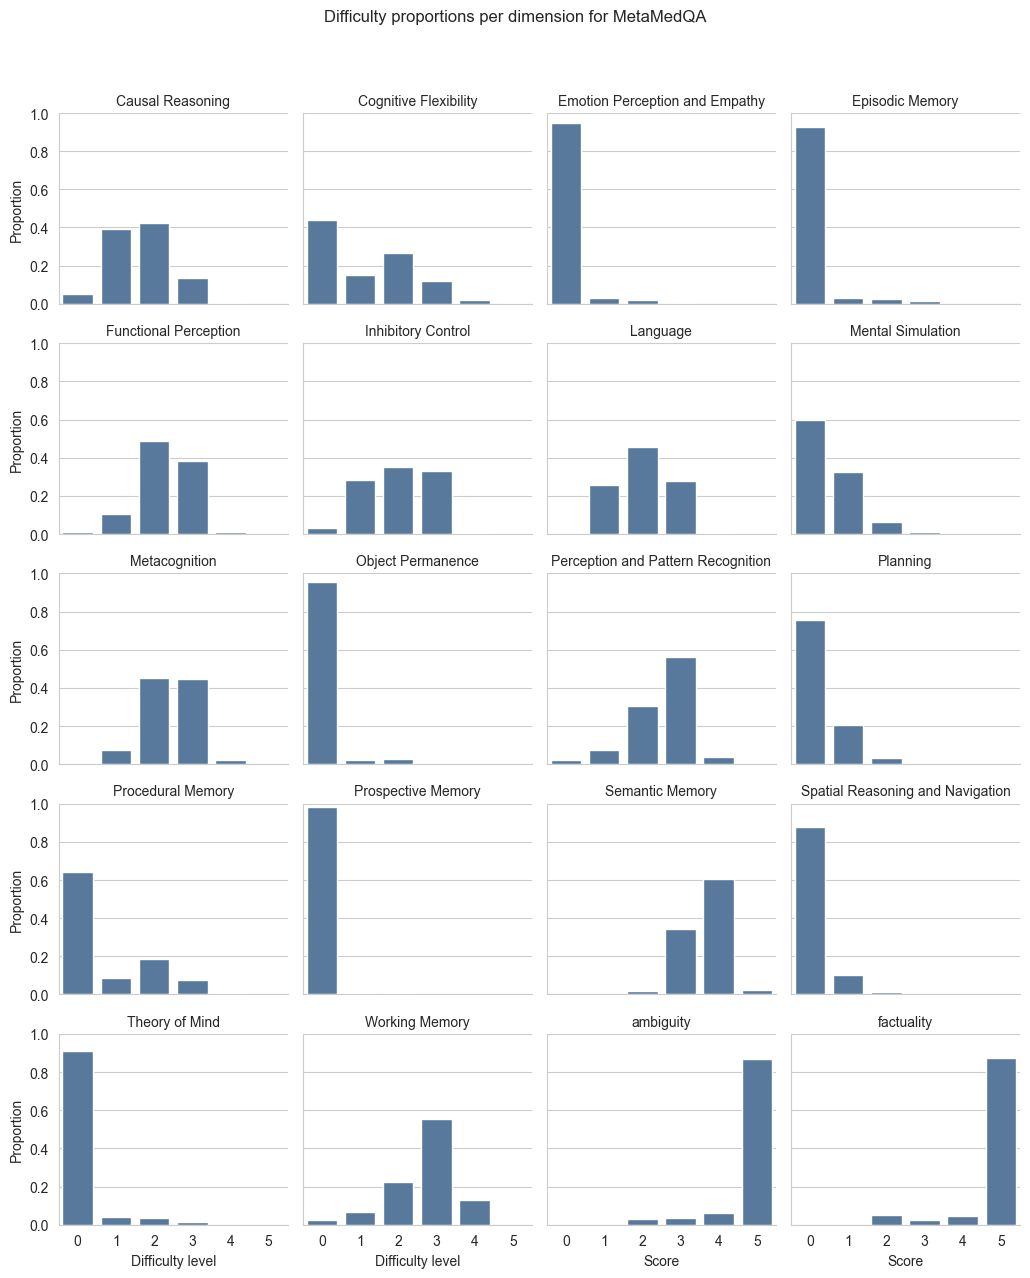

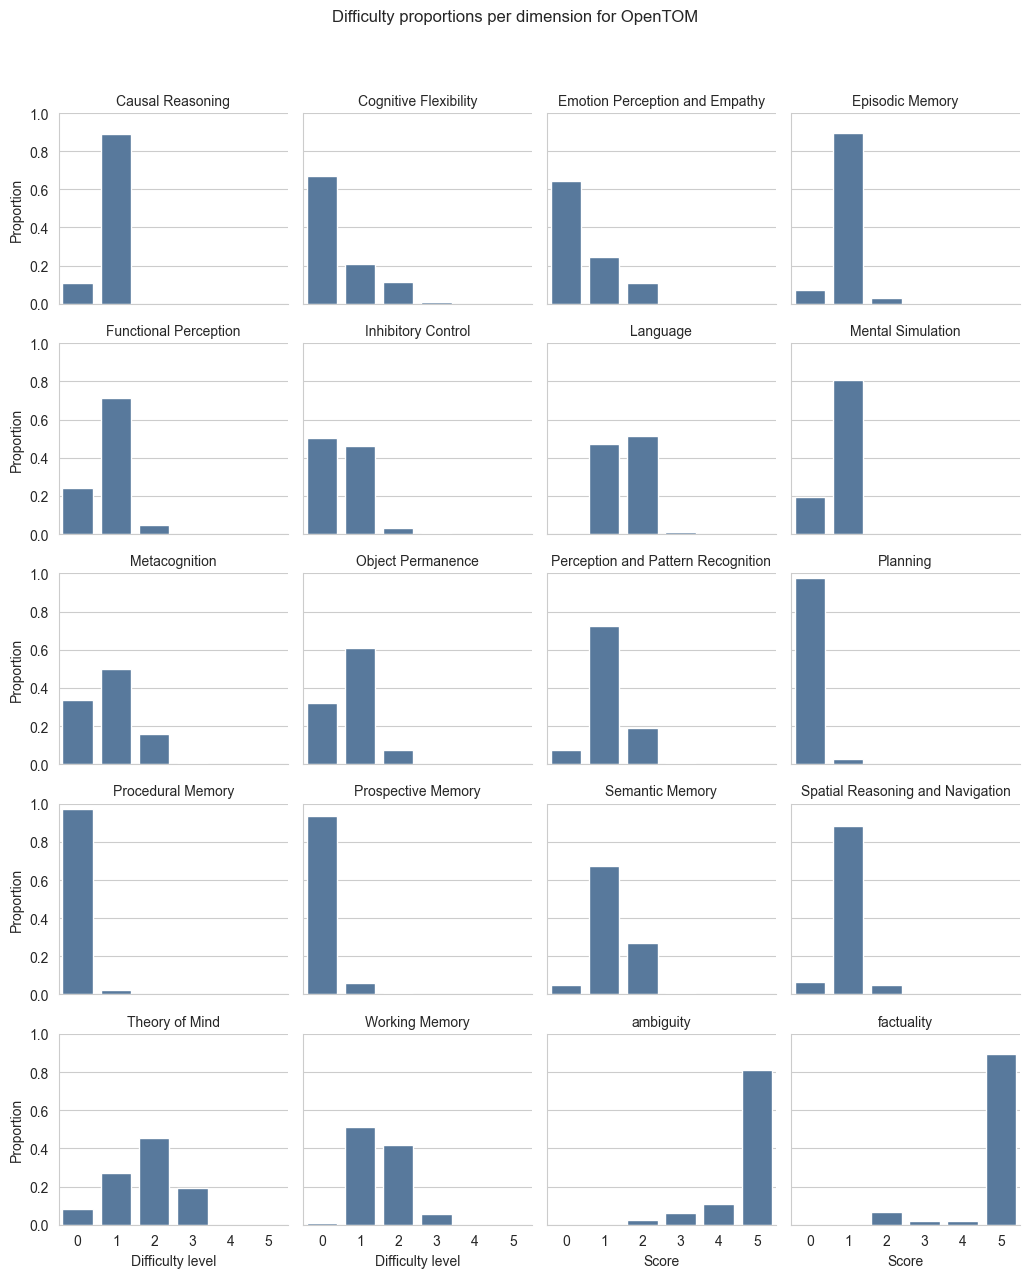

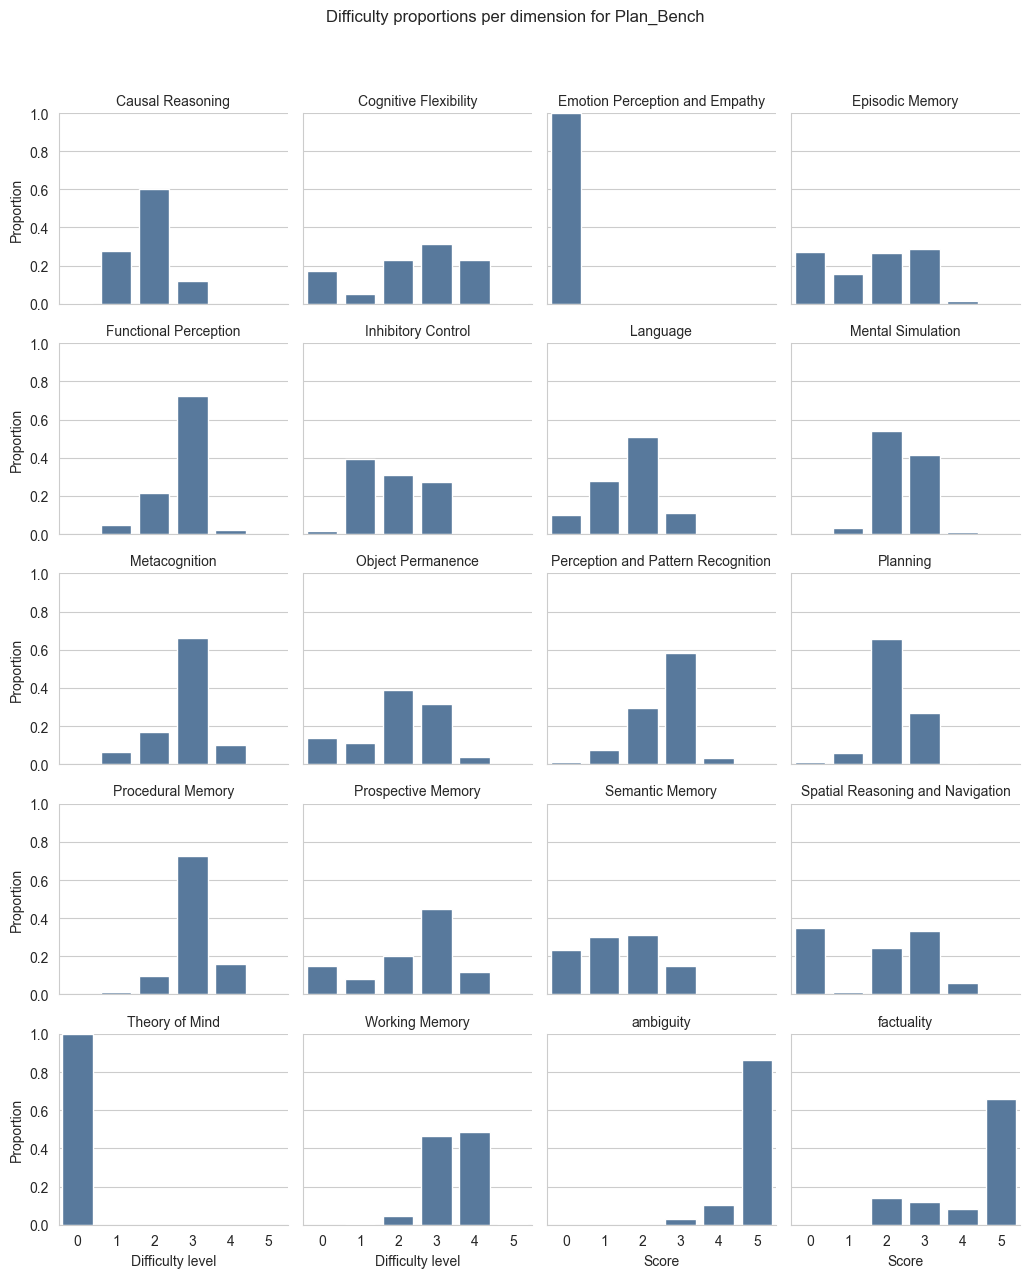

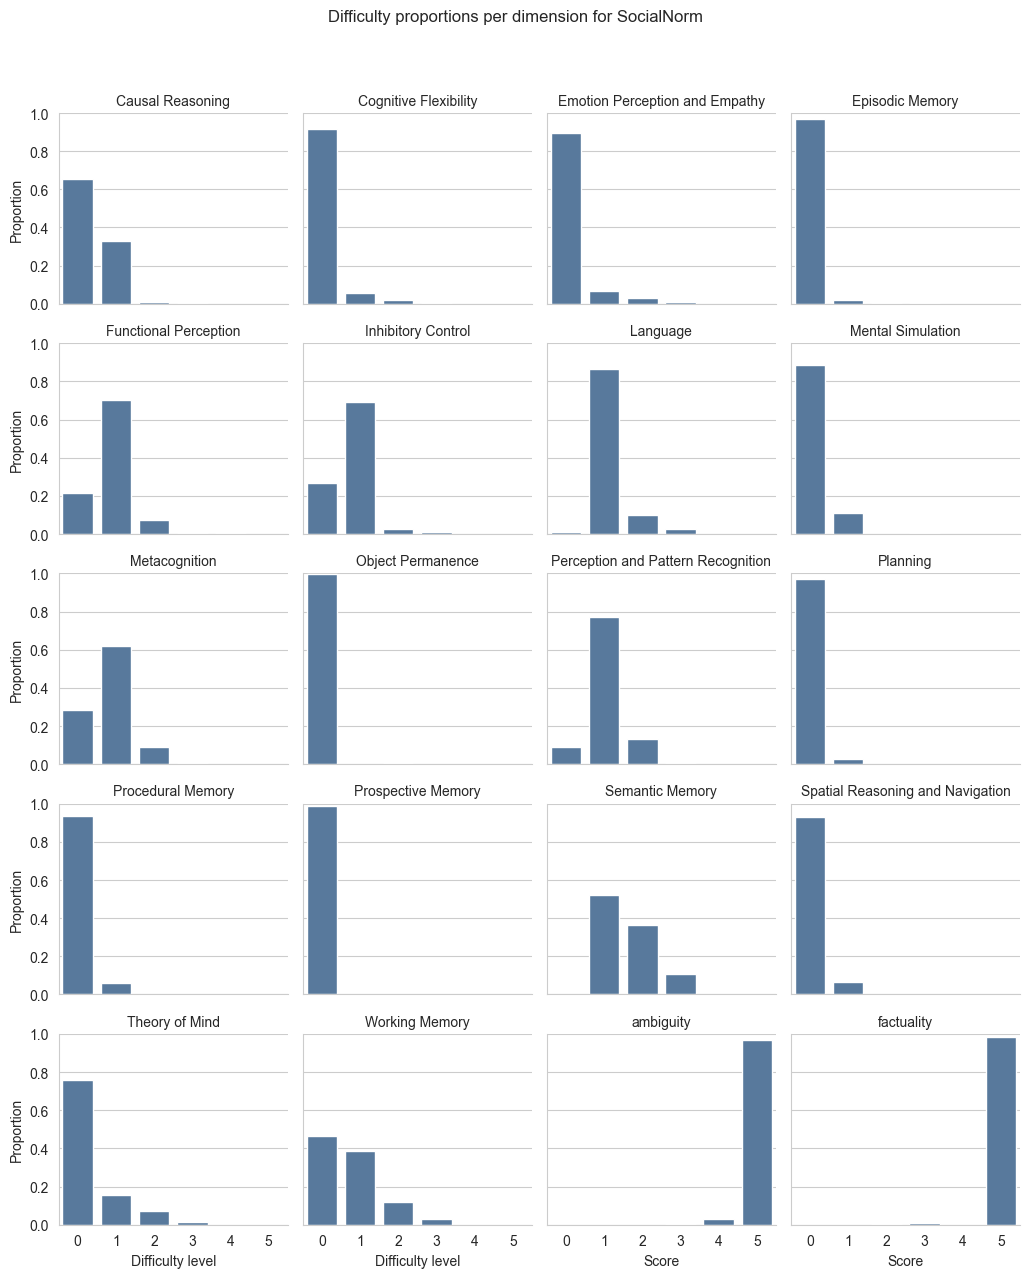

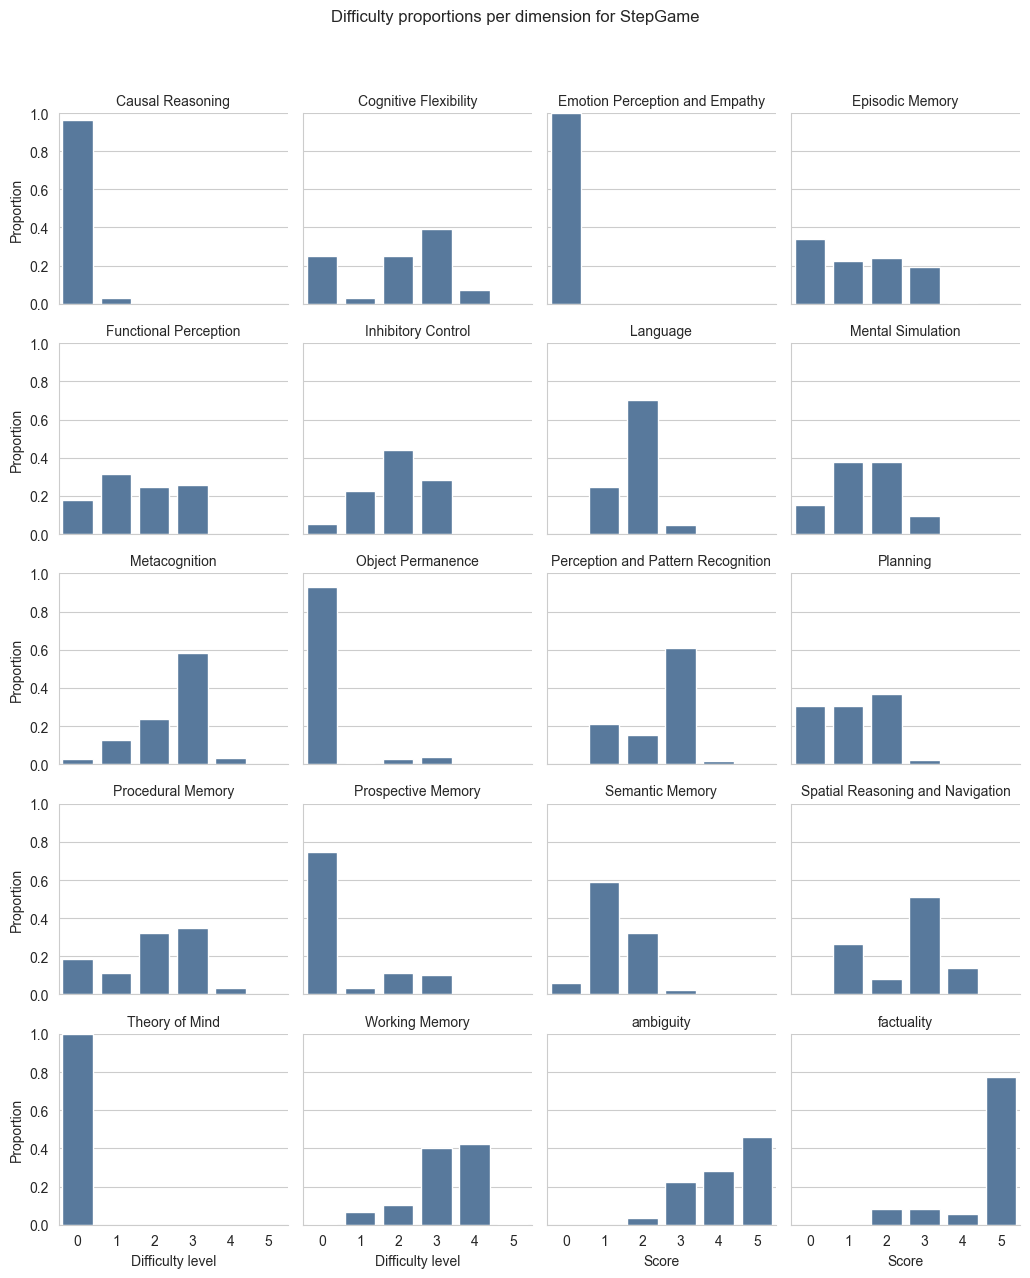

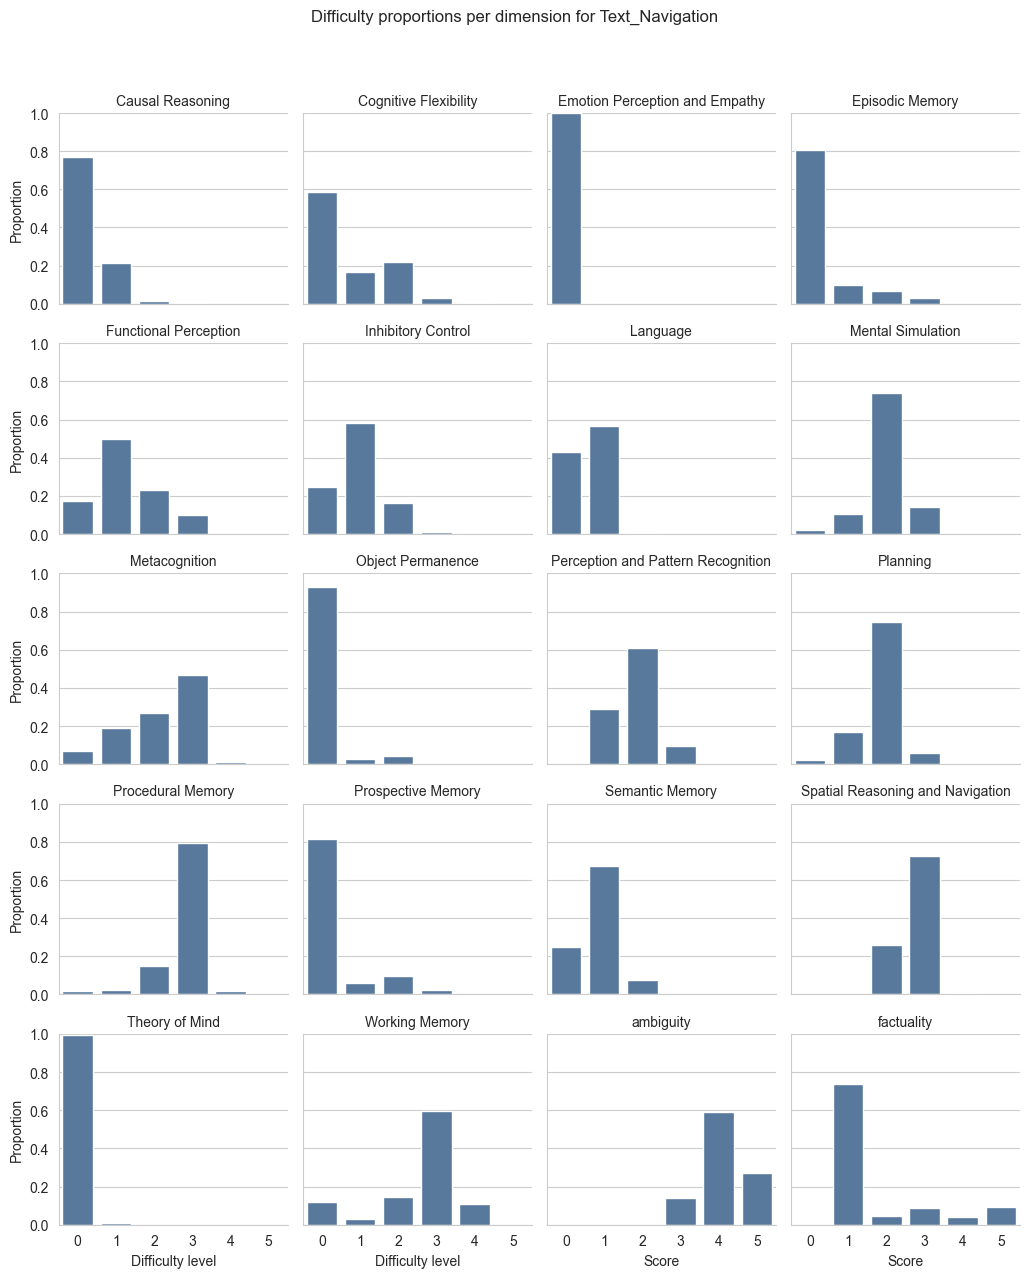

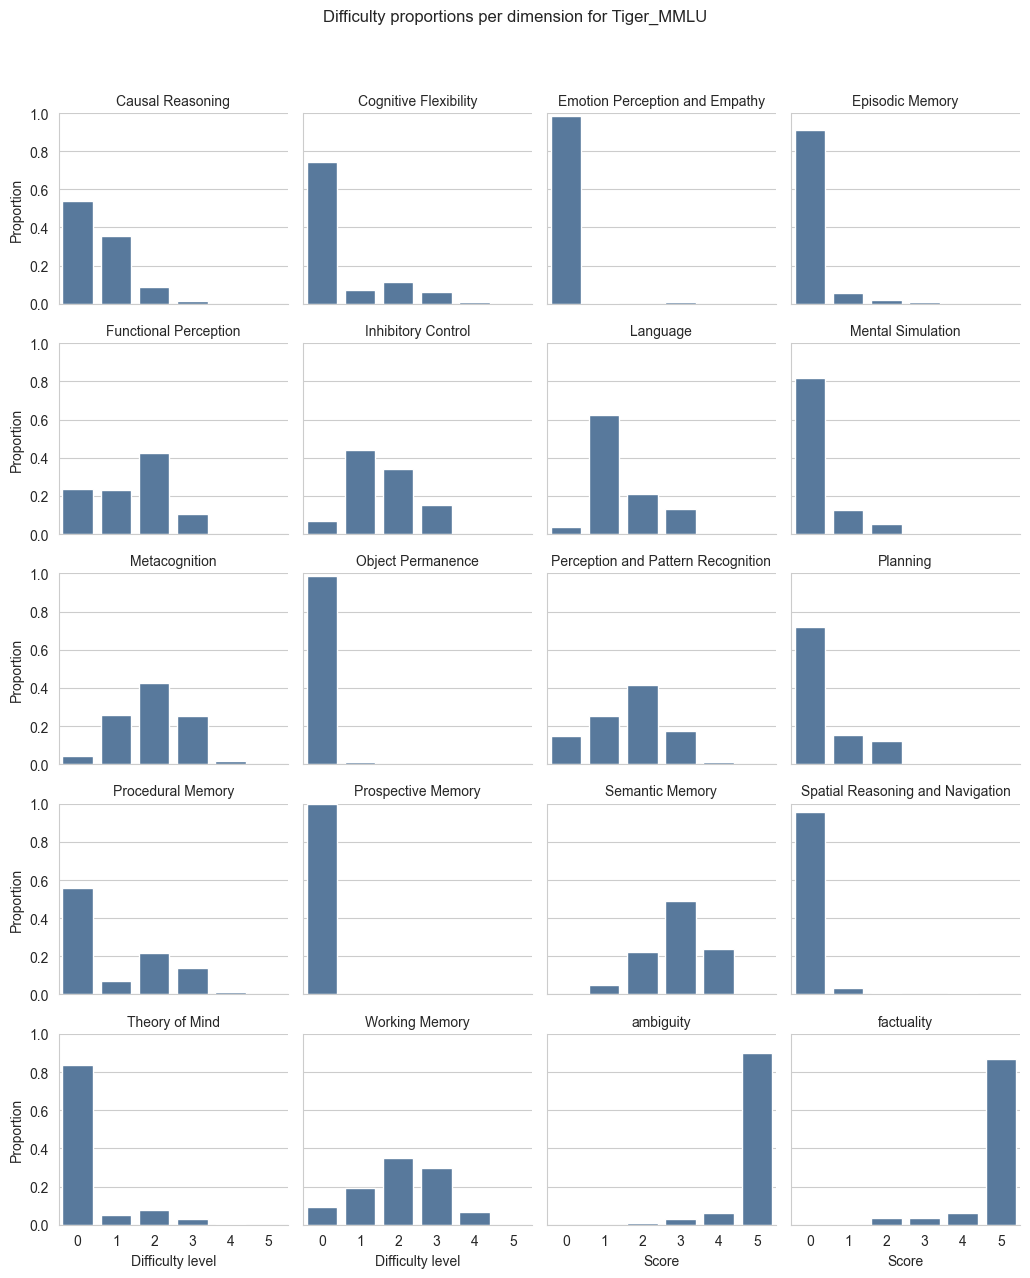

In [26]:
for ds in datasets:
    df_ds = plot_df[plot_df["dataset name"] == ds]
    g = sns.FacetGrid(
        df_ds, col="dimension", col_wrap=4,
        sharex=True, sharey=True, height=2.6, margin_titles=True
    )
    # Use estimator=None to plot provided p_hat values directly
    g.map_dataframe(
        sns.barplot, x="difficulty", y="Proportion",
        color="#4C78A8",
    )
    g.set_titles("{col_name}")
    g.set_xlabels("Difficulty level")
    g.set_ylabels("Proportion")
    # Override x-label for specific dimensions
    for ax in g.axes.flat:
        if ax is None:
            continue
        title = ax.get_title()  # equals the dimension name from {col_name}
        if title in {"ambiguity", "factuality"}:
            ax.set_xlabel("Score")
        ax.set_ylim(0, 1)
    plt.subplots_adjust(top=0.9)
    g.figure.suptitle(f"Difficulty proportions per dimension for {ds}")
    plt.show()

# Polar plots

In [27]:
CAPABILITY_CODES = {
    "Causal Reasoning": "CR",
    "Cognitive Flexibility": "CF",
    "Emotion Perception and Empathy": "EPE",
    "Episodic Memory": "EM",
    "Functional Perception": "FP",
    "Inhibitory Control": "IC",
    "Language": "LG",
    "Mental Simulation": "MS",
    "Metacognition": "MC",
    "Object Permanence": "OP",
    "Perception and Pattern Recognition": "PPR",
    "Planning": "PL",
    "Procedural Memory": "PM",
    "Prospective Memory": "PrM",
    "Semantic Memory": "SM",
    "Spatial Reasoning and Navigation": "SRN",
    "Theory of Mind": "ToM",
    "Working Memory": "WM",
}

EXCLUDE_DIMS = {"ambiguity", "factuality"}

ORDERED_DIMS = [
    "Episodic Memory", "Semantic Memory", "Procedural Memory", "Prospective Memory", "Working Memory",
    "Inhibitory Control", "Cognitive Flexibility",
    "Perception and Pattern Recognition", "Functional Perception", "Spatial Reasoning and Navigation", "Object Permanence",
    "Theory of Mind", "Emotion Perception and Empathy",
    "Language", "Mental Simulation", "Metacognition",
    "Causal Reasoning", "Planning",
]


In [28]:
SCORE_BINS = list(range(6))
counts = (
    data_filtered
    .groupby(["dataset name", "dimension", "score"], observed=True)
    .size()
    .unstack("score", fill_value=0)
    .reindex(columns=SCORE_BINS, fill_value=0)
    .sort_index()  # ensures MultiIndex order
)

In [29]:
counts.head()

score                                              0    1    2   3   4  5
dataset name     dimension                                               
AGIEval_freeform Causal Reasoning                848   26    9   1   0  0
                 Cognitive Flexibility           565   46  168  94  11  0
                 Emotion Perception and Empathy  884    0    0   0   0  0
                 Episodic Memory                 883    0    1   0   0  0
                 Functional Perception           418  117  270  79   0  0

## Polar plots for each benchmark separaterly

In [30]:
# --- helper: polar heatmap for one dataset ---
def plot_polar_counts_for_dataset(
    counts: pd.DataFrame,
    dataset_name: str,
    base_color: str = "#30638e",
    width: float = 12.0,
    height: float = 12.0,
    dpi: int = 300,
    base_font_size: int = 16,
    out_dir: str = ".",
):
    """
    counts: DataFrame indexed by ['dataset name','dimension'], columns = 0..5 (score bins)
    """
    # slice one dataset
    if ("dataset name" not in counts.index.names) or ("dimension" not in counts.index.names):
        raise ValueError("counts must have a MultiIndex with ['dataset name','dimension'].")

    if dataset_name not in counts.index.get_level_values("dataset name"):
        raise ValueError(f"Dataset '{dataset_name}' not found in counts index.")

    sub = counts.xs(dataset_name, level="dataset name")

    # filter & enforce order
    dims_present = [d for d in ORDERED_DIMS if d in sub.index and d not in EXCLUDE_DIMS]
    if not dims_present:
        raise ValueError("No matching dimensions to plot after filtering.")

    sub = sub.loc[dims_present, SCORE_BINS]  # ensure rows in desired order, columns 0..5

    # build counts matrix: rows=0..5 (radial), cols=dimensions (angular)
    counts_matrix = sub.to_numpy().T  # shape (6, n_dims)

    # polar grid edges
    n_dims = sub.shape[0]
    theta_edges = np.linspace(0, 2*np.pi, n_dims + 1)
    r_edges = np.arange(-0.5, 6.5, 1.0)

    # color map: white -> base_color
    cmap = LinearSegmentedColormap.from_list("white_to_base", ["#FFFFFF", base_color])

    # figure
    fig = plt.figure(figsize=(width, height), dpi=dpi)
    ax = fig.add_subplot(111, projection="polar")

    mesh = ax.pcolormesh(theta_edges, r_edges, counts_matrix, cmap=cmap)

    # separators like ggplot hlines
    for y in np.arange(-0.5, 5.6, 1.0):
        ax.plot([0, 2*np.pi], [y, y], linewidth=0.5, color="#66666E")

    # radial limits & custom labels
    ax.set_rlim(-0.5, 5.5)
    ax.set_rticks(range(0, 6))
    ax.set_yticklabels([])

    # angular ticks (use shorthands)
    theta_centers = 0.5 * (theta_edges[:-1] + theta_edges[1:])
    tick_labels = [CAPABILITY_CODES.get(d, d) for d in dims_present]
    # angular ticks (use shorthands) but manually offset labels outward
    ax.set_xticks([])  # hide default ticks

    # distance multiplier > 1 moves them slightly away from outer ring
    label_radius = 6   # try 5.2–5.6 depending on how much space you want
    for angle, label in zip(theta_centers, tick_labels):
        ax.text(
            angle,
            label_radius,
            label,
            fontsize=base_font_size,
            ha="center",
            va="center",
            rotation=np.degrees(0),
            rotation_mode="anchor",
    )

    # bold, centered radial labels near angle 0
    for y in range(0, 6):
        ax.text(
            np.deg2rad(0),  # small negative angle keeps labels inside the ring
            y,
            str(y),
            ha="center",      # centers the text horizontally
            va="center",
            fontsize=int(base_font_size * 0.9),
            fontweight="bold",
            transform=ax.transData,
        )

    ax.grid(False)
    ax.set_title(
        dataset_name,
        va="bottom",
        fontsize=base_font_size + 4,
        fontweight="bold",
        pad=48,   # increase this value to move title higher (try 30–60)
    )

    cbar = plt.colorbar(mesh, ax=ax, pad=0.1)
    cbar.ax.tick_params(labelsize=max(base_font_size - 2, 8))
    cbar.set_label("", rotation=0)

    # save
    os.makedirs(out_dir, exist_ok=True)
    out_path = os.path.join(out_dir, f"{dataset_name}_polar_counts.png")
    plt.savefig(out_path, dpi=dpi, bbox_inches="tight")
    plt.close(fig)
    return out_path

# --- helper: plot all datasets in counts ---
def plot_all_datasets_polar(counts: pd.DataFrame, **kwargs):
    datasets = counts.index.get_level_values("dataset name").unique().tolist()
    outputs = []
    for ds in datasets:
        try:
            outputs.append(plot_polar_counts_for_dataset(counts, ds, **kwargs))
        except Exception as e:
            print(f"Skip {ds}: {e}")
    return outputs

In [31]:
plot_all_datasets_polar(counts, base_color="#30638e", out_dir="plots")

['plots/AGIEval_freeform_polar_counts.png',
 'plots/AGIEval_mcq_polar_counts.png',
 'plots/Abstract_Narrative_Understanding_polar_counts.png',
 'plots/BigBenchHard_polar_counts.png',
 'plots/BigToM_polar_counts.png',
 'plots/Cause_and_Effect_polar_counts.png',
 'plots/CoQA_polar_counts.png',
 'plots/Crow_polar_counts.png',
 'plots/EWoK_polar_counts.png',
 'plots/EmoBench_polar_counts.png',
 'plots/Evaluating_Information_Essentiality_polar_counts.png',
 'plots/Fantasy_Reasoning_polar_counts.png',
 'plots/Fantom_polar_counts.png',
 'plots/INTUIT_polar_counts.png',
 'plots/Known_Unknowns_polar_counts.png',
 'plots/LLM_BabyBench_decompose_polar_counts.png',
 'plots/LLM_BabyBench_plan_polar_counts.png',
 'plots/LLM_BabyBench_predict_polar_counts.png',
 'plots/MacGyver_polar_counts.png',
 'plots/MetaMedQA_polar_counts.png',
 'plots/OpenTOM_polar_counts.png',
 'plots/Plan_Bench_polar_counts.png',
 'plots/SocialNorm_polar_counts.png',
 'plots/StepGame_polar_counts.png',
 'plots/Text_Navigation

## Global counts over all items

In [32]:
global_counts.head()

score,0,1,2,3,4,5
dimension,,,,,,
Causal Reasoning,7406,9682,2519,451,5,0
Cognitive Flexibility,9995,3064,4029,2302,661,12
Emotion Perception and Empathy,16267,1973,1661,155,7,0
Episodic Memory,11224,5196,2340,1261,42,0
Functional Perception,3680,8319,4203,3465,389,7


In [33]:
def plot_polar_counts_global(
        counts: pd.DataFrame,
        title: str = "Global counts (all benchmarks)",
        base_color: str = "#30638e",
        width: float = 12.0,
        height: float = 12.0,
        dpi: int = 300,
        base_font_size: int = 16,
        out_path: str | None = None,
):
    """
    Plot a single polar heatmap for global counts across all datasets.

    Parameters
    ----------
    counts : pd.DataFrame
        Either:
          A) MultiIndex index ['dataset name','dimension'] with columns 0..5 (score bins).
             In this case, this function will sum across 'dataset name'.
          B) Index 'dimension' with columns 0..5 (already global).
    """

    # Normalize to a per-dimension counts table with columns SCORE_BINS
    if ("dataset name" in counts.index.names) and ("dimension" in counts.index.names):
        # case A: sum over datasets to global
        sub = (
            counts
            .groupby("dimension")
            .sum()
            .reindex(ORDERED_DIMS, axis=0, fill_value=0)
        )
    else:
        # case B: already per-dimension
        if "dimension" not in getattr(counts.index, "names", [None]) and counts.index.name != "dimension":
            # assume it's already indexed by dimension without a name
            sub = counts.copy()
            sub.index.name = "dimension"
        else:
            sub = counts.copy()

        # enforce order and remove excluded dims
        sub = sub.loc[[d for d in ORDERED_DIMS if d in sub.index and d not in EXCLUDE_DIMS]]

    # ensure columns 0..5 exist in order
    sub = sub.reindex(columns=SCORE_BINS, fill_value=0)

    # build counts matrix: rows=0..5 (radial), cols=dimensions (angular)
    counts_matrix = sub.to_numpy().T  # shape (6, n_dims)

    # polar grid edges
    n_dims = sub.shape[0]
    if n_dims == 0:
        raise ValueError("No dimensions to plot.")
    theta_edges = np.linspace(0, 2 * np.pi, n_dims + 1)
    r_edges = np.arange(-0.5, 6.5, 1.0)

    # color map: white -> base_color
    cmap = LinearSegmentedColormap.from_list("white_to_base", ["#FFFFFF", base_color])

    # figure
    fig = plt.figure(figsize=(width, height), dpi=dpi)
    ax = fig.add_subplot(111, projection="polar")

    mesh = ax.pcolormesh(theta_edges, r_edges, counts_matrix, cmap=cmap)

    # separators like ggplot hlines
    for y in np.arange(-0.5, 5.6, 1.0):
        ax.plot([0, 2 * np.pi], [y, y], linewidth=0.5, color="#66666E")

    # category separators
        for t in theta_edges:
            ax.plot([t, t], [r_edges[0], r_edges[-1]], color="white", lw=1.0, zorder=3)

    # radial limits & custom labels
    ax.set_rlim(-0.5, 5.5)
    ax.set_rticks(range(0, 6))
    ax.set_yticklabels([])

    # angular ticks (use shorthands), labels slightly outside
    theta_centers = 0.5 * (theta_edges[:-1] + theta_edges[1:])
    tick_labels = [CAPABILITY_CODES.get(d, d) for d in sub.index.tolist()]
    ax.set_xticks([])

    label_radius = 6.0
    for angle, label in zip(theta_centers, tick_labels):
        ax.text(
            angle,
            label_radius,
            label,
            fontsize=base_font_size,
            ha="center",
            va="center",
        )

    # bold radial labels
    for y in range(0, 6):
        ax.text(
            np.deg2rad(0),
            y,
            str(y),
            ha="center",
            va="center",
            fontsize=int(base_font_size * 0.9),
            fontweight="bold",
            transform=ax.transData,
        )

    ax.grid(False)
    ax.set_title(
        title,
        va="bottom",
        fontsize=base_font_size + 4,
        fontweight="bold",
        pad=48,
    )

    cbar = plt.colorbar(mesh, ax=ax, pad=0.1)
    cbar.ax.tick_params(labelsize=max(base_font_size - 2, 8))
    cbar.set_label("", rotation=0)

    if out_path:
        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        plt.savefig(out_path, dpi=dpi, bbox_inches="tight")
        plt.close(fig)
        return out_path
    else:
        plt.show()
        return None


In [34]:
plot_polar_counts_global(global_counts, title="All items", out_path="plots/global_polar_counts.png")

'plots/global_polar_counts.png'

## Grid plot of all benchmarks

In [35]:
def plot_polar_counts_grid(
    counts: pd.DataFrame,
    ncols: int = 5,
    base_color: str = "#30638e",
    figsize_per_cell: float = 3.0,
    base_font_size: int = 10,
    show_labels: bool = True,
    tight_layout: bool = True,
    cbar_width: str = "4%",     # width of each subplot colorbar
    cbar_height: str = "50%",   # height of each subplot colorbar
    out_path: str | None = None,
    dpi: int = 300
):
    if ("dataset name" not in counts.index.names) or ("dimension" not in counts.index.names):
        raise ValueError("counts must have a MultiIndex with ['dataset name','dimension'].")

    datasets = counts.index.get_level_values("dataset name").unique().tolist()
    if not datasets:
        raise ValueError("No datasets to plot.")

    n = len(datasets)
    ncols = max(1, ncols)
    nrows = math.ceil(n / ncols)
    fig_w = figsize_per_cell * ncols
    fig_h = figsize_per_cell * nrows
    fig, axes = plt.subplots(
        nrows, ncols, subplot_kw={"projection": "polar"},
        figsize=(fig_w, fig_h), dpi=300
    )
    axes = np.array(axes).reshape(nrows, ncols)

    cmap = LinearSegmentedColormap.from_list("white_to_base", ["#FFFFFF", base_color])
    SCORE_BINS = list(range(6))
    r_edges = np.arange(-0.5, 6.5, 1.0)

    for idx, ds in enumerate(datasets):
        r, c = divmod(idx, ncols)
        ax = axes[r, c]
        sub = counts.xs(ds, level="dataset name")

        dims_present = [d for d in ORDERED_DIMS if d in sub.index and d not in EXCLUDE_DIMS]
        if not dims_present:
            ax.set_axis_off()
            ax.set_title(ds, fontsize=base_font_size, pad=8)
            continue

        sub = sub.loc[dims_present, SCORE_BINS]
        counts_matrix = sub.to_numpy().T

        n_dims = sub.shape[0]
        theta_edges = np.linspace(0, 2*np.pi, n_dims + 1)

        # per-axes normalization (own scale)
        vmin, vmax = np.nanmin(counts_matrix), np.nanmax(counts_matrix)
        if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin == vmax:
            # safe fallback to avoid zero-range colorbars
            vmin, vmax = 0.0, 1.0
        norm = Normalize(vmin=vmin, vmax=vmax)

        mesh = ax.pcolormesh(theta_edges, r_edges, counts_matrix, cmap=cmap, norm=norm)

        # radial separators
        for y in np.arange(-0.5, 5.6, 1.0):
            ax.plot([0, 2*np.pi], [y, y], linewidth=0.4, color="#999999", alpha=0.6, zorder=2)

        # category separators
        for t in theta_edges:
            ax.plot([t, t], [r_edges[0], r_edges[-1]], color="white", lw=1.0, zorder=3)

        ax.set_rlim(-0.5, 5.5)
        ax.set_rticks(range(0, 6))
        ax.set_yticklabels([])
        ax.set_xticks([])

        if show_labels:
            theta_centers = 0.5 * (theta_edges[:-1] + theta_edges[1:])
            tick_labels = [CAPABILITY_CODES.get(d, d) for d in sub.index.tolist()]
            label_radius = 6.3
            for angle, label in zip(theta_centers, tick_labels):
                ax.text(angle, label_radius, label, fontsize=max(base_font_size - 2, 8),
                        ha="center", va="center")

        for y in range(0, 6):
            ax.text(np.deg2rad(0), y, str(y), ha="center", va="center",
                    fontsize=max(base_font_size - 3, 7), fontweight="bold", zorder=4)

        ax.grid(False)
        ax.set_title(ds, va="bottom", fontsize=base_font_size, fontweight="bold", pad=25)

        # per-subplot colorbar (inset on the right)
        cax = inset_axes(ax, width=cbar_width, height=cbar_height, loc="center right",
                         bbox_to_anchor=(0.3, 0.0, 0.9, 1.0),  # shift slightly inside axes
                         bbox_transform=ax.transAxes, borderpad=0)
        cbar = plt.colorbar(mesh, cax=cax)
        cbar.ax.tick_params(labelsize=max(base_font_size - 3, 7))

    # turn off any extra axes
    for extra in range(len(datasets), nrows * ncols):
        r, c = divmod(extra, ncols)
        axes[r, c].set_axis_off()

    if tight_layout:
        #plt.tight_layout()
        fig.subplots_adjust(wspace=0.7, hspace=0.1, left=0.05, right=0.98, top=0.95, bottom=0.05)

    if out_path:
        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        fig.savefig(out_path, dpi=dpi, bbox_inches="tight")
        plt.close(fig)
        return out_path
    else:
        plt.show()
        return None


In [36]:
plot_polar_counts_grid(counts, ncols=4, out_path="plots/polar_counts_grid.png")

'plots/polar_counts_grid.png'